# Capstone Project - Finnish...

## Assignment Instructions from the course

Coursera Course: _Applied Data Science Capstone_

You have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to *explore or compare neighborhoods or cities*
of your choice **or** to *come up with a problem that you can use the Foursquare location data to solve*. If you cannot think of an idea or a problem, here are some ideas to get you started:

1. In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine this idea.

2. In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?

These are just a couple of many ideas and problems that can be solved using location data in addition to other datasets. No matter what you decide to do, make sure to provide sufficient justification of why you think what you want to do or solve is important and why would a client or a group of people be interested in your project.


For the first week, you will required to submit the following:

1. A description of the problem and a discussion of the background. (15 marks)
2. A description of the data and how it will be used to solve the problem. (15 marks)


For the second week, the final deliverables of the project will be:

1. A link to your Notebook on your Github repository, showing your code. (15 marks)
2. A full report consisting of all of the following components (15 marks):
    - **Introduction** where you discuss the business problem and who would be interested in this project.
    - **Data** where you describe the data that will be used to solve the problem and the source of the data.
    - **Methodology** section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.
    - **Results** section where you discuss the results.
    - **Discussion** section where you discuss any observations you noted and any recommendations you can make based on the results.
    - **Conclusion** section where you conclude the report.
3. Your choice of a presentation or blogpost. (10 marks)


## Working notes

Wikipedia:
- Luettelo Suomen kunnista, sisältäen mm. väkiluku ja pinta-ala: https://fi.wikipedia.org/wiki/Luettelo_Suomen_kunnista
- Luettelo Suomen maakunnista, sis samat: https://fi.wikipedia.org/wiki/Suomen_maakunnat
- Luettelo Suomen postinumeroista kunnittain: https://fi.wikipedia.org/wiki/Luettelo_Suomen_postinumeroista_kunnittain


- http://tilastokeskus.fi/org/avoindata/paikkatietoaineistot.html

Tilastokeskus, Paavo:
- Tilastokeskus, Paavo kuvaus (postinumeroalueittainen avoin tieto): http://tilastokeskus.fi/tup/paavo/paavo_kuvaus_fi.pdf
- Tilastokeskuksen PX-Web-tietokannat (Paavo): http://pxnet2.stat.fi/PXWeb/pxweb/fi/Postinumeroalueittainen_avoin_tieto/
- PX-Web:ssä valittu 2019 -aineisto => 9. Kaikki tietoryhmät (päivitetty 22.1.2019) ja seuraavalla sivulla valittu kaikki postinumeroalueet ja kaikki tiedot => valinta yhteensä 314 808 taulukkosolua, lataus "puolipiste-eroteltu (otsikollinen)".  Tallennettu tiedostoon *paavo_9_koko.csv*
- from the saved file, first two rows (empty rows in the beginning of the file) were removed.
- coordinates used: **EUREF-FIN** coordinate system (**ETRS89-TM35FIN**)


- toinen lähde: http://spatialreference.org/ref/epsg/?search=finland&srtext=Search
- antaa EPSG:2393: KKJ / Finland Uniform Coordinate System
- tämäkin lähde auttoi: http://www.kolumbus.fi/eino.uikkanen/geodocsgb/ficoords.htm
- Test coordinates visually (are they in right place) here: https://suomenkartta.fi/karttakoordinaatit/


Protocol: Web Feature Service (WFS)
- In python lib OWSLib 0.17.1 here: https://geopython.github.io/OWSLib/
- returns GML files?


# Solution

- Using FourSquare to access venue data in selected areas
- Using Folium to show results on map
- Using Paavo data to get finnish postal codes and some information about each postal code area

...


# Step 0.1 - Workbook basic settings

Use the following variable to control certain aspects of this workbook.

In [1]:

### -----------------------------------------------------
###
### Paavo dataset
###
###

# Paavo data filename.
PAAVO_FILENAME = 'paavo_9_koko_en_tab.csv'


### -----------------------------------------------------
###
### Foursquare venue dataset
###
###

# This is the file where the downloaded Foursquare data is stored in CSV format.
FS_DATA_FILENAME = "FourSquare_downloaded_venues_new.csv"

# Change these values IF YOU DO WANT downloading to happen.  In most cases we should already have the venue data downloaded, so these
# should be False for not downloading.
#
FS_DOWNLOAD_ALL = False
FS_DOWNLOAD_SELECTED = False

# If you want to download the data, then also fill in these values.

FS_CLIENT_ID = '<YOUR_CLIENT_ID>' # your Foursquare ID
FS_CLIENT_SECRET = '<YOUR_CLIENT_SECRET>' # your Foursquare Secret



## Step 0.2 - Import libraries

In [2]:
import pandas as pd # library for data analsysis

# Show floats in two decimals
# Note: this has global effect on all DataFrames!
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import os
import math
import requests # library to handle requests
import operator

#!conda install -c conda-forge folium=0.5.0 --yes
# OR
#!pip install folium
import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

#!pip install seaborn
import seaborn as sns

# Need to install pyproj first, if possible, check this out...
#!pip install pyproj
import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [3]:
# Axure environment has pandas 0.19.2, it has differences compared to 0.24.1 which is used here
#!pip install --upgrade pandas

# Axure environment has seaborn 0.8, it has differences compared to 0.9.9 which is used here
#!pip install --upgrade seaborn


# Step 0.3 - Helper functions

These are gathered here to make the rest of the workbook a bit more readable.

In [4]:

### ---------------------------------------------------------
###
### Helper functions for Paavo data Enhancement
###
###

# Following three helper functions assume Paavo 'postal code' field value has
# Structure: 'NNNN <postal code area name> (<city name>)'
# Example: '00120 Punavuori (Helsinki )'

# Return the postal code number from Paavo 'postal code' field value
def get_pc_number(pc):
    return pc[:5].strip()

# Return the city name from Paavo 'postal code' field value
def get_city_name(pc):
    loc = pc.find('(')
    return pc[loc:].strip('() ')

# Return the postal code area name from Paavo 'postal code' field value
def get_pc_area_name(pc):
    loc = pc.find('(')
    return pc[5:loc].strip()
    
print("get_pc_number() defined.")
print("get_city_name() defined.")
print("get_pc_area_name() defined.")


# Helper functions to analyze / report data values.

# Helper function to do the filtering of paavo data and report to user how the filtering goes.
# For the given dataframe, filter out rows that have less than 30 inhabitants in a given column.
# Processes one column at a time, so for multiple columns to clean, multiple calls are needed.
def paavo_filter_rows_on_column(df, col_index):
    col_name = df.columns[col_index]
    print("Cleaning away postal codes which have less than 30 inhabitants in column\n", col_name)
    count_before = df.shape[0]
    filtered_df = df[df[col_name] >= 30]
    count_after = filtered_df.shape[0]
    print("\tPostal Codes cleaned away:   ", count_before - count_after)
    print("\tContinuing with:              ", count_after, "Postal Codes\n")
    return filtered_df

print("paavo_filter_rows_on_column() defined.")


# Helper / convenience function to add relative metrics into a dataframe.
# new_col_name value will be col1_name / col2_name.
# Additionally sorts the new column right after the latter of input columns. 
def add_relative_metric_into_df(df, new_col_name, col1_name, col2_name):

    # first do the adding of the metrics
    df[new_col_name] = df[col1_name] / df[col2_name]
    df_cols = df.columns.tolist()

    # then position the new metric right of the col1, col2, whichever is more to the right. 
    col1_index = df_cols.index(col1_name)
    col2_index = df_cols.index(col2_name)
    df_cols.remove(new_col_name)
    df_cols.insert(max(col1_index, col2_index) + 1, new_col_name)
    df = df[df_cols]

    return df

print('add_relative_metric_into_df() defined.')



### ---------------------------------------------------------
###
### Generic helper functions
###
###


# Reorders list content.  Whole is a list, in which we want to sort elements of top to the beginning.
# Parameters 'top' and 'whole' are both lists.  Every element of 'top' must be in 'whole'.
# Returns a new list, does not modify input parameters.
def list_order_to_top(top, whole):
    # Check that all elements in top are also in whole
    for t in top:
        if t not in whole:
            raise Exception("joo")
    rest = []
    for w in whole:
        if w not in top:
            rest = rest + [w]
    return top + rest


# Find out how many of each value there are in a list.
# Takes in a list and returns a dictionary, whose keys are list values, and values are # of occurrences on list
def list_find_uniques_with_counts(l, key_counts={}):
    for list_value in l:
        list_value = str(list_value)
        if list_value in key_counts.keys():
            key_counts[list_value] = key_counts[list_value] + 1
        else:
            key_counts[list_value] = 1
    return key_counts


# Pretty print the uniques with their counts.  Takes in the output dictionary
# that is returned from list_find_uniques_with_counts
def print_uniques_with_counts_dict(key_counts, print_threshold=0, total_values=0):
    for i in (range(len(key_counts.keys()))):
        max_key = max(key_counts.items(), key=operator.itemgetter(1))[0]
        if total_values == 0:
            total_percentage = ""
        else:
            total_percentage = int(100*(key_counts[max_key]/total_values))
        if key_counts[max_key] > print_threshold:
            print("{:>25} -- {:3} ({:2}%)".format(max_key, key_counts[max_key], total_percentage))
        key_counts.pop(max_key, None)


# Calculate the euclidian distance between points 1 and 2. Typically points are two dimensional,
# but here they can have any dimension, as long as they have the same dimensions.
# parameters point1 and point2 are lists of equal length, and their values must be numerical.
# Returns the distance.
def euclidian_distance(point1, point2):
    if len(point1) != len(point2):
        raise Exception("Input lists are not of equal length!")
    cum_sum = 0
    for x1, x2 in zip(point1, point2):
        cum_sum = cum_sum + (x1 - x2)**2
    return math.sqrt(cum_sum)


print("list_order_to_top() defined.")
print("list_find_uniques_with_counts() defined.")
print("print_uniques_with_counts_dict() defined.")
print("euclidian_distance() defined.")



### ---------------------------------------------------------
###
### Foursquare specific helper functions and definitions.
###
###



# FourSquare call parameters
FS_VERSION = '20180604'
FS_LIMIT = 50 # This is maximum

fs_venue_data_columns = [
    'PC', 
    'PC Latitude', 
    'PC Longitude',
    'Venue Id',
    'Venue', 
    'Venue Latitude', 
    'Venue Longitude', 
    'Venue Category']


# fs_download_nearby_venues accesses Foursquare's explore -endpoint to download venue data, and returns a dataframe.
# Helper function from 2nd lab of week 3
def fs_download_nearby_venues(postal_codes, latitudes, longitudes, radius=500, section=False):
    
    venues_list=[]
    for pc, lat, lng in zip(postal_codes, latitudes, longitudes):
        #print(pc)

        # create the API request URL
        url = ""
        if section:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
                FS_CLIENT_ID, FS_CLIENT_SECRET, FS_VERSION, lat, lng, radius, section, FS_LIMIT)
        else:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                FS_CLIENT_ID, FS_CLIENT_SECRET, FS_VERSION, lat, lng, radius, FS_LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                pc, lat, lng,
                v['venue']['id'],
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']
            ) for v in results])
        except:
            print("SOMETHING WENT WRONG DOWNLOADING {} FROM FourSquare".format(pc))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    if nearby_venues.shape[0] == 0:
        nearby_venues = pd.DataFrame(columns=fs_venue_data_columns)
    else:
        nearby_venues.columns = fs_venue_data_columns
    
    return(nearby_venues)


print("fs_download_nearby_venues() defined")


# For each postal code in the input paavo_df, check if it already has some downloaded venue data in fs_venue_df.
# If not, then download venue data, otherwhise skip to next postal code in paavo_df.  Update the downloaded results
# directly to the fs_venue_df.
#
# Input paavo_df can be all of the paavo data or any subset of selected rows from it - this update focuses only on the
# postal codes included in the input paavo_df.
#
# Note that as the result limit from Foursquare is 50 venues.  If the returned result set indeed contains that maximum
# amount of venues, then we seek for more venue data by doing additional but more focused downloads to food, coffee and
# drinks categories. 

def fs_ensure_downloaded_venues_for_postal_codes(paavo_df):
    global fs_venue_df
    work_df = paavo_df
    print("Filter results in {} postal codes. Starting...".format(work_df.shape[0]))

    # Loop through each postal code, check if there are already venues for it in fs_venue_df.
    # If yes, skip to next postal code, if not then download data and add it to fs_venue_df.
    for pc in work_df["PC"].tolist():
        #print(pc, type(pc))
        if fs_venue_df[fs_venue_df["PC"] == pc].shape[0] == 0:
            # No previous data, download and add
            print("downloading venues for {} from Foursquare.".format(pc), end="")
            
            pc_row_df = work_df[work_df["PC"] == pc]
            lon = pc_row_df.iloc[0,2]
            lat = pc_row_df.iloc[0,3]
            area = pc_row_df.iloc[0,6]
            r = int(math.sqrt(area))
            new_venues_df = fs_download_nearby_venues([pc], [lat], [lon], r)
            fs_venue_df = pd.concat([fs_venue_df, new_venues_df])
            count = new_venues_df.shape[0]
            print("  Received {} venues.".format(count), end="")
            if count == 50:
                print(" More food, coffee and drinks?", end="")
                # Check for more 'food', 'drinks' and 'coffee' venues with the section info
                new_venues_df = fs_download_nearby_venues([pc], [lat], [lon], r, 'food')
                fs_venue_df = pd.concat([fs_venue_df, new_venues_df])
                new_venues_df = fs_download_nearby_venues([pc], [lat], [lon], r, 'coffee')
                fs_venue_df = pd.concat([fs_venue_df, new_venues_df])
                new_venues_df = fs_download_nearby_venues([pc], [lat], [lon], r, 'drinks')
                fs_venue_df = pd.concat([fs_venue_df, new_venues_df])
            print(" Done.")
                
    print("Done.")


print("fs_ensure_downloaded_venues_for_postal_codes() defined.")


# Save fs_venue_df to a local file and test it by reading it back and comparing the dataframe shapes.
#
# It is worthwhile to save the data every now and then, as it is
# a lot of downloading, takes a lot time, and something can fail.

def fs_save_venues_to_file():
    fs_venue_df.to_csv(FS_DATA_FILENAME, index=False)

    # Check via reading data back in
    test_read_df = pd.read_csv(FS_DATA_FILENAME)
    if fs_venue_df.shape == test_read_df.shape:
        print("File saved successfully with {} rows of data.".format(fs_venue_df.shape[0]))
        # Release this data from memory, it was just for testing.
        test_read_df = None
    else:
        print("Something is wrong, files do not match.")
        print("Data shape:", fs_venue_df.shape)
        print("File shape:", test_read_df.shape)
        test_read_df = None

print("fs_save_venues_to_file() defined.")



### ---------------------------------------------------------
###
### Clustering specific helper functions and definitions.
###
###



# Helper to find us a value for k.  Return highest k such that resulting clusters still have at least size_min_limit elements.
def get_KMeans_clusters_with_best_k(cluster_df, size_min_limit = 2):
    proposed_k = 1
    for loop_kclusters in range(2, 15):
        clusters = KMeans(n_clusters=loop_kclusters, random_state=0).fit(bare_clustering_1_df).labels_
        clusters_counts_d = list_find_uniques_with_counts(clusters, {}) # returns a dictionary
        clusters_counts_l = list(clusters_counts_d.values())
        clusters_counts_l.sort(reverse=True)
        if clusters_counts_l[-1] >= size_min_limit:
            proposed_k = loop_kclusters
        print("cluster count: {:>2}, cluster sizes (sorted by size): {}".format(loop_kclusters, clusters_counts_l))

    print("\nProposing k = {} for clusters count (smallest clusters size is still at least {} elements)".format(proposed_k, size_min_limit))

    # Run the clustering algorithm with different values of K to see what size of clusters emerge.
    # Choose k such that all resulting clusters are still bigger than 1 in size.

    kclusters = proposed_k

    # run k-means clustering final time
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

    # check cluster labels generated for each row in the dataframe
    print("\n\nClustered", len(kmeans.labels_), "postal code areas into", kclusters, "clusters.\n")

    return proposed_k, kmeans.labels_

print('get_KMeans_clusters_with_best_k() defined.')


def get_ordered_new_cluster_labels(clusters):
    new_labels_digit = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

    cluster_relabel_df = pd.DataFrame(clusters)
    cluster_relabel_df.columns = ['ClusterLabel']
    cluster_relabel_df["count"] = np.ones(len(clusters))
    cluster_relabel_df = cluster_relabel_df.groupby("ClusterLabel").count()

    cluster_relabel_df.sort_values('count', ascending=False, inplace=True)
    cluster_relabel_df['Cluster'] = new_labels_digit[:k]
    cluster_relabel_df = cluster_relabel_df.reset_index()
    cluster_relabel_df.sort_values('ClusterLabel', ascending=True, inplace=True)
    return cluster_relabel_df['Cluster'].tolist()
    

print('get_ordered_new_cluster_labels() defined.')




get_pc_number() defined.
get_city_name() defined.
get_pc_area_name() defined.
paavo_filter_rows_on_column() defined.
add_relative_metric_into_df() defined.
list_order_to_top() defined.
list_find_uniques_with_counts() defined.
print_uniques_with_counts_dict() defined.
euclidian_distance() defined.
fs_download_nearby_venues() defined
fs_ensure_downloaded_venues_for_postal_codes() defined.
fs_save_venues_to_file() defined.
get_KMeans_clusters_with_best_k() defined.
get_ordered_new_cluster_labels() defined.


## Step 1 - Paavo data

### Step 1.1 - Download Paavo data

**NOTE: this has already been done, this is just documentation on how to redo it if necessary.**

Paavo data is available for download through a couple of different methods.  The following 'Graphical User Interface' -method was used in this study.

Paavo data was obtained from here: http://pxnet2.stat.fi/PXWeb/pxweb/en/Postinumeroalueittainen_avoin_tieto/?rxid=4e21d676-5dd1-4575-ab30-d35b741089d4

Following screenshots detail the selections made to download the data to local computer.

**First, choose the year whose data you desire.  This study used the 2019 dataset:**

<img src="Paavo_download_1.JPG" style="width: 800px;">

**Then choose the statistics content you wish.  This study used the whole dataset:**

<img src="Paavo_download_2.JPG" style="width: 800px;">

**Finally you select the postal code areas you like and the statistical content fields in more detail.  Also choose the format for the download file. For this study we selected all postal code areas, all variables and a tab delimited format (kind of CSV):**

<img src="Paavo_download_3.JPG" style="width: 800px;">

**After downloading the data, the file's top two rows were removed, as they messed up the import process later.  The 1st removed row contained a title for the dataset and the 2nd removed row was empty.**

Then the Paavo data was ready to use.

### Step 1.2 - Load Paavo data

In [5]:

paavo_df = None

if os.path.isfile(PAAVO_FILENAME):

    paavo_df = pd.read_csv(PAAVO_FILENAME, sep='\t', encoding='iso-8859-1')
    print("Loaded Paavo data.\nFound {} rows and {} columns of data.".format(paavo_df.shape[0], paavo_df.shape[1]))

else:
    print("Did not find data file:", PAAVO_FILENAME)

# Show a sample of data to understand what we have
paavo_df.head()

Loaded Paavo data.
Found 3027 rows and 105 columns of data.


,Postal code area,X coordinate in metres,Y coordinate in metres,Surface area,"Inhabitants, total, 2017 (HE)","Females, 2017 (HE)","Males, 2017 (HE)","Average age of inhabitants, 2017 (HE)","0-2 years, 2017 (HE)","3-6 years, 2017 (HE)",...,"T Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use, 2016 (TP)","U Activities of extraterritorial organisations and bodies, 2016 (TP)","X Industry unknown, 2016 (TP)","Inhabitants, 2016 (PT)","Employed, 2016 (PT)","Unemployed, 2016 (PT)","Children aged 0 to 14, 2016 (PT)","Students, 2016 (PT)","Pensioners, 2016 (PT)","Others, 2016 (PT)"
0,Finland,429300,7084490,390813692400,5513130,2793999,2719131,42,160297,240994,...,656,343,59,5503297,2275679,355837,894178,407905,1389830,179868
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,385114,6672391,2353278,18284,9613,8671,41,434,521,...,0,17,1,18035,10032,856,1812,1198,3326,811
2,00120 Punavuori (Helsinki ),385614,6671378,414010,7108,3751,3357,40,183,234,...,0,0,0,7055,3872,336,817,428,1242,360
3,00130 Kaartinkaupunki (Helsinki ),386228,6671492,428960,1508,772,736,41,34,48,...,0,12,0,1522,839,61,170,104,258,90
4,00140 Kaivopuisto - Ullanlinna (Helsinki ),386410,6670742,931841,7865,4277,3588,41,224,250,...,0,1,0,7934,4218,325,929,518,1519,425


### Step 1.3 - Paavo data, exploration

Here we explore the pure Paavo data features / columns as they are available from Tilastokeskus, that is, no fixes, cleaning or data manipulation on values.

Paavo data contains data in 105 columns for 3026 postal codes plus for the whole finland as well.  Below are the different datacolumns and their values for whole Finland, Helsinki downtown and a random rural area. The data is from years 2016 and 2017, depending on the data.

In [6]:
# Store this for later use
paavo_stat_variables_list = paavo_df.columns.tolist()[3:]

In [7]:
# Create a subset dataframe to inspect data.  In the transposed dataframe:
#    - Column 0 is for whole Finland,
#    - Column 1 is for postal code 00100 (Finlands Capital, center)
#    - Column 2600 is for postal code 89840 (very rural area)
#
paavo_fin_df = paavo_df.T[[0, 1, 2600]]
paavo_fin_df.columns = ["Whole Finland", paavo_df.iloc[1,0], paavo_df.iloc[2600,0]]


#### Step 1.3.1 - Paavo data exploration - population and age groups, 2017

In [8]:
paavo_fin_df[4:28]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Inhabitants, total, 2017 (HE)",5513130,18284,57
"Females, 2017 (HE)",2793999,9613,20
"Males, 2017 (HE)",2719131,8671,37
"Average age of inhabitants, 2017 (HE)",42,41,63
"0-2 years, 2017 (HE)",160297,434,0
"3-6 years, 2017 (HE)",240994,521,0
"7-12 years, 2017 (HE)",369950,711,0
"13-15 years, 2017 (HE)",177163,274,0
"16-17 years, 2017 (HE)",117857,185,0
"18-19 years, 2017 (HE)",120218,264,1


#### Step 1.3.2 - Paavo data exploration - Education, 2017

In [9]:
paavo_fin_df[28:35]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Aged 18 or over, total, 2017 (KO)",4446869,16159,57
"Basic level studies, 2017 (KO)",1112261,1996,30
"With education, total, 2017 (KO)",3334608,14163,27
"Matriculation examination, 2017 (KO)",303230,2618,1
"Vocational diploma, 2017 (KO)",2035528,2942,24
"Academic degree - Lower level university degree, 2017 (KO)",518969,2899,2
"Academic degree - Higher level university degree, 2017 (KO)",476881,5704,0


#### Step 1.3.3 - Paavo data exploration - Inhabitant income, 2016

In [10]:
paavo_fin_df[35:42]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Aged 18 or over, total, 2016 (HR)",4431392,15935,60
"Average income of inhabitants, 2016 (HR)",23812,38985,16166
"Median income of inhabitants, 2016 (HR)",20925,26642,14939
"Inhabintants belonging to the lowest income category, 2016 (HR)",886431,2856,26
"Inhabitants belonging to the middle income category, 2016 (HR)",2658687,6668,31
"Inhabintants belonging to the highest income category, 2016 (HR)",886274,6411,3
"Accumulated purchasing power of inhabitants, 2016 (HR)",105520349469,621218859,969978


#### Step 1.3.4 - Paavo data exploration - Households, 2017

In [11]:
paavo_fin_df[42:57]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Households, total, 2017 (TE)",2680077,10205,34
"Average size of households, 2017 (TE)",2.0,1.8,1.7
"Occupancy rate, 2017 (TE)",40.5,38.6,56.4
"Young single persons, 2017 (TE)",291052,2101,1
"Young couples without children, 2017 (TE)",115168,861,0
"Households with children, 2017 (TE)",570112,1326,0
"Households with small children, 2017 (TE)",142781,400,0
"Households with children under school age, 2017 (TE)",278849,715,0
"Households with school-age children, 2017 (TE)",263490,541,0
"Households with teenagers, 2017 (TE)",221106,373,0


#### Step 1.3.5 - Paavo data exploration - Household income, 2016

In [12]:
paavo_fin_df[57:64]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Households, total, 2016 (TR)",2654657,10042,36
"Average income of households, 2016 (TR)",39270,61679,26975
"Median income of households, 2016 (TR)",31824,38895,23598
"Households belonging to the lowest income category, 2016 (TR)",677223,1697,13
"Households belonging to the middle income category, 2016 (TR)",1500917,4123,22
"Households belonging to the highest income category, 2016 (TR)",476517,4222,1
"Accumulated purchasing power of households, 2016 (TR)",104247634221,619383515,971110


#### Step 1.3.6 - Paavo data exploration - Buildings, 2017

In [13]:
paavo_fin_df[64:72]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Free-time residences, 2017 (RA)",507200,0,103
"Buildings, total, 2017 (RA)",1523196,634,90
"Other buildings, 2017 (RA)",228770,326,14
"Residential buildings, 2017 (RA)",1294426,308,76
"Dwellings, 2017 (RA)",2946814,11884,48
"Average floor area, 2017 (RA)",80.1,65.9,97.7
"Dwellings in small houses, 2017 (RA)",1568029,2,48
"Dwellings in blocks of flats, 2017 (RA)",1378785,11882,0


#### Step 1.3.7 - Paavo data exploration - Jobs, 2016

In [14]:
paavo_fin_df[72:98]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Workplaces, 2016 (TP)",2094313,48470,16
"Primary production, 2016 (TP)",56104,104,0
"Processing, 2016 (TP)",461153,1805,0
"Services, 2016 (TP)",1576997,46560,16
"A Agriculture, forestry and fishing, 2016 (TP)",56104,104,0
"B Mining and quarrying, 2016 (TP)",5283,0,0
"C Manufacturing, 2016 (TP)",283209,752,0
"D Electricity, gas, steam and air conditioning supply, 2016 (TP)",11714,554,0
"E Water supply; sewerage, waste management and remediation activities, 2016 (TP)",10703,1,0
"F Construction, 2016 (TP)",150244,498,0


#### Step 1.3.8 - Paavo data exploration - Main type of activity, 2016

In [15]:
paavo_fin_df[98:]

,Whole Finland,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,89840 Ylä-Vuokki (Suomussalmi )
"Inhabitants, 2016 (PT)",5503297,18035,61
"Employed, 2016 (PT)",2275679,10032,13
"Unemployed, 2016 (PT)",355837,856,6
"Children aged 0 to 14, 2016 (PT)",894178,1812,0
"Students, 2016 (PT)",407905,1198,1
"Pensioners, 2016 (PT)",1389830,3326,40
"Others, 2016 (PT)",179868,811,1


### Step 1.4 - Clean data

Paavo contains ".." values (two dots) in certain columns for such postal code areas where there are less than 30 cases in total for the data section.  Here cleaning means removing such rows from data so that we have only numeric values in columns other than the first column. 

Also, drop the first row of data which contains totals for whole Finland.

But first, define some helper functions.

Check the distribution of Paavo data column dtypes (of the dataframe). Remember, there are 105 columns in total.

In [16]:
t1 = paavo_df.dtypes.tolist()
d = list_find_uniques_with_counts(t1)
print_uniques_with_counts_dict(d, 0, 105)

                   object --  91 (86%)
                    int64 --  14 (13%)


So, many columns are not numeric type.  Now clean the ".." dots away.

In [17]:
print("\nCleaning Paavo data, start with {} postal codes.\n".format(paavo_df.shape[0]))

paavo_filtered_df = paavo_df

# filter on population structure (age) having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 4)

# filter on education having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 28)

# filter on income having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 35)

# filter on households having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 42)

# filter on household income having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 57)

# filter on jobs having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 72)

# filter on main type of activity having less than 30 cases
paavo_filtered_df = paavo_filter_rows_on_column(paavo_filtered_df, 98)



Cleaning Paavo data, start with 3027 postal codes.

Cleaning away postal codes which have less than 30 inhabitants in column
 Inhabitants, total, 2017 (HE)
	Postal Codes cleaned away:    75
	Continuing with:               2952 Postal Codes

Cleaning away postal codes which have less than 30 inhabitants in column
 Aged 18 or over, total, 2017 (KO)
	Postal Codes cleaned away:    11
	Continuing with:               2941 Postal Codes

Cleaning away postal codes which have less than 30 inhabitants in column
 Aged 18 or over, total, 2016 (HR)
	Postal Codes cleaned away:    4
	Continuing with:               2937 Postal Codes

Cleaning away postal codes which have less than 30 inhabitants in column
 Households, total, 2017 (TE)
	Postal Codes cleaned away:    107
	Continuing with:               2830 Postal Codes

Cleaning away postal codes which have less than 30 inhabitants in column
 Households, total, 2016 (TR)
	Postal Codes cleaned away:    1
	Continuing with:               2829 Postal Code

Then try to convert the rest of columns to some numeric type, preferrence order is int, int64 and float.

In [18]:
print("Ensure number values in columns from 3 to end.\n")
for i in range(3, len(paavo_filtered_df.columns)):
    colname = paavo_filtered_df.columns[i]
    # don't convert floats, as they would become ints and lose the decimal parts.
    if str(paavo_filtered_df.iloc[:,i].dtype) != "float64":
        try:
            paavo_filtered_df.iloc[:,i] = paavo_filtered_df.iloc[:,i].astype("int")
        except:
            try:
                paavo_filtered_df.iloc[:,i] = paavo_filtered_df.iloc[:,i].astype(np.int64)
            except:
                try:
                    paavo_filtered_df.iloc[:,i] = paavo_filtered_df.iloc[:,i].astype("float")
                except:
                    print("*** Failed to convert {}th column ({}) to number".format(i, colname))

print("Column data types after cleaning:\n")
                    
t1 = paavo_filtered_df.dtypes.tolist()
d = list_find_uniques_with_counts(t1)
print_uniques_with_counts_dict(d, 0, 105)

Ensure number values in columns from 3 to end.

Column data types after cleaning:

                    int32 --  97 (92%)
                    int64 --   4 ( 3%)
                  float64 --   3 ( 2%)
                   object --   1 ( 0%)


Drop Finland country level totals from further analysis and check the data head after cleaning.

In [19]:
paavo_filtered_df = paavo_filtered_df.iloc[1:,:]
paavo_filtered_df.reset_index(inplace=True)
paavo_filtered_df.drop(["index"], axis=1, inplace=True)
paavo_filtered_df.head()

,Postal code area,X coordinate in metres,Y coordinate in metres,Surface area,"Inhabitants, total, 2017 (HE)","Females, 2017 (HE)","Males, 2017 (HE)","Average age of inhabitants, 2017 (HE)","0-2 years, 2017 (HE)","3-6 years, 2017 (HE)",...,"T Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use, 2016 (TP)","U Activities of extraterritorial organisations and bodies, 2016 (TP)","X Industry unknown, 2016 (TP)","Inhabitants, 2016 (PT)","Employed, 2016 (PT)","Unemployed, 2016 (PT)","Children aged 0 to 14, 2016 (PT)","Students, 2016 (PT)","Pensioners, 2016 (PT)","Others, 2016 (PT)"
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki,385114,6672391,2353278,18284,9613,8671,41,434,521,...,0,17,1,18035,10032,856,1812,1198,3326,811
1,00120 Punavuori (Helsinki ),385614,6671378,414010,7108,3751,3357,40,183,234,...,0,0,0,7055,3872,336,817,428,1242,360
2,00130 Kaartinkaupunki (Helsinki ),386228,6671492,428960,1508,772,736,41,34,48,...,0,12,0,1522,839,61,170,104,258,90
3,00140 Kaivopuisto - Ullanlinna (Helsinki ),386410,6670742,931841,7865,4277,3588,41,224,250,...,0,1,0,7934,4218,325,929,518,1519,425
4,00150 Eira - Hernesaari (Helsinki ),385235,6670549,1367328,9496,5129,4367,40,250,282,...,7,8,0,9527,5433,536,942,564,1523,529


### Step 1.5 - Enhance the data

1. Latitude and Longitude values for coordinates in addition to the metric X and Y values (use pyproj for this)
2. Separate the postal code number (5 digits) into a column of its own
3. Separate the city name (in parenthes) into a column of its own
4. Separate the postal code area name (the rest, between number and city name) into a column of its own.
5. Change the surface area data values from square meters into square kilometers (divide by 1 000 000)


In [20]:
# store original columns for easier sorting of new columns to the beginning
orig_cols = paavo_filtered_df.columns.tolist()

# 1. Get the latitude and longitude values, based on X and Y meters.
p = pyproj.Proj(proj='utm',zone=35,ellps='WGS84') # use kwarg
x_list = paavo_filtered_df.iloc[:,1].tolist()
y_list = paavo_filtered_df.iloc[:,2].tolist()
lon_list, lat_list = p(x_list, y_list, inverse=True)

# Add latitude and longitude into data
paavo_filtered_df["PC Longitude"] = lon_list
paavo_filtered_df["PC Latitude"] = lat_list

# 2. Create postal code number into a new column
paavo_filtered_df["PC"] = paavo_filtered_df.iloc[:,0].str.slice(stop=5)

# 3. Create city name into a new column
paavo_filtered_df["City"] = paavo_filtered_df.iloc[:,0].map(get_city_name)

# 4. change old postal code column into one containing only the name
paavo_filtered_df["Postal code area"] = paavo_filtered_df["Postal code area"].map(get_pc_area_name)


# Sort the columns so that the new columns are on the left side (easier to see)
new_cols = ["PC", "Postal code area", "City", "PC Longitude", "PC Latitude"]
paavo_filtered_df = paavo_filtered_df[list_order_to_top(new_cols, paavo_filtered_df.columns.tolist())]
paavo_filtered_df.rename(columns={"Postal code area": "PC Name"}, inplace=True)

paavo_filtered_df["Surface area"] = paavo_filtered_df["Surface area"] / 1000000

paavo_filtered_df.head()

,PC,PC Name,City,PC Longitude,PC Latitude,X coordinate in metres,Y coordinate in metres,Surface area,"Inhabitants, total, 2017 (HE)","Females, 2017 (HE)",...,"T Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use, 2016 (TP)","U Activities of extraterritorial organisations and bodies, 2016 (TP)","X Industry unknown, 2016 (TP)","Inhabitants, 2016 (PT)","Employed, 2016 (PT)","Unemployed, 2016 (PT)","Children aged 0 to 14, 2016 (PT)","Students, 2016 (PT)","Pensioners, 2016 (PT)","Others, 2016 (PT)"
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,24.93,60.17,385114,6672391,2.35,18284,9613,...,0,17,1,18035,10032,856,1812,1198,3326,811
1,00120,Punavuori,Helsinki,24.94,60.16,385614,6671378,0.41,7108,3751,...,0,0,0,7055,3872,336,817,428,1242,360
2,00130,Kaartinkaupunki,Helsinki,24.95,60.16,386228,6671492,0.43,1508,772,...,0,12,0,1522,839,61,170,104,258,90
3,00140,Kaivopuisto - Ullanlinna,Helsinki,24.95,60.16,386410,6670742,0.93,7865,4277,...,0,1,0,7934,4218,325,929,518,1519,425
4,00150,Eira - Hernesaari,Helsinki,24.93,60.16,385235,6670549,1.37,9496,5129,...,7,8,0,9527,5433,536,942,564,1523,529


## Step 2 - Foursquare venue data

### Step 2.1 - Download Foursquare data to a local CSV file (just once!)

This section contains code to download the venue data from Foursquare to a local CSV file.  Doing this is not necessary, if you already have the data in a downloaded CSV file.

If you want to redownload the data change the variable XXX to XXX and remove the target file if it exists.

Define more FS\_ parameters and helper functions so that we can easily get venue data for those locations that we choose.

In [21]:

# Create a empty dataframe with correct columns.
fs_venue_df = pd.DataFrame(columns=fs_venue_data_columns)

# If we are downloading something, and if we have already downloaded some data, read it from file so that we
# don't do unnecessary work (downloading takes some time, ther are many calls to Foursquare and a maximum of
# two calls per second on average (limitation on Foursquare side))
if FS_DOWNLOAD_ALL or FS_DOWNLOAD_SELECTED:
    if os.path.isfile(FS_DATA_FILENAME):
        print("Found existing data, appending it.")
        fs_venue_df = pd.read_csv(FS_DATA_FILENAME, dtype={"PC": 'str'})
        print(fs_venue_df.shape)


# From experience we know that downloading all the data gives us over 30 000 rows of data into the file
if FS_DOWNLOAD_ALL:
    # Run the download for all postal code areas and saving data to disk

    last_l_limit = 0

    # Loop downloading in small sections of 100 postal codes and save into file
    for u_limit in list(range(0, paavo_filtered_df.shape[0], 100)):
        l_limit = u_limit - 200
        l_limit = max(0, l_limit)
        last_l_limit = l_limit
        print("Working on range:", l_limit, u_limit)
        count_before = fs_venue_df.shape[0]
        fs_ensure_downloaded_venues_for_postal_codes(paavo_filtered_df.iloc[l_limit:u_limit,:])
        count_after = fs_venue_df.shape[0]
        print("Venue data has now {} rows of data.".format(count_after))
        if count_after > count_before:
            fs_save_venues_to_file()

    # Make sure we got the last ones, too
    print("Working on final range from", l_limit, "to the end.")
    count_before = fs_venue_df.shape[0]
    fs_ensure_downloaded_venues_for_postal_codes(paavo_filtered_df.iloc[last_l_limit:,:])
    count_after = fs_venue_df.shape[0]
    print("Venue data has now {} rows of data.".format(count_after))
    if count_after > count_before:
        fs_save_venues_to_file()
    
    # Finally, remove any duplicate rows. A row is duplicate if its venue id and postal code values are the same.
    # There can be some for postal codes with over 50 venues, because in such cases we additionally downloaded
    # focusing only on restaurants, coffee shops and drinking places.
    #
    # Note: same venue id might still exist for different postal code areas.
    #
    # If there are duplicate rows, they are identical so just take the first in such cases
    fs_venue_df = fs_venue_df.groupby(["PC", "Venue Id"]).first().reset_index()
    fs_venue_df = fs_venue_df[fs_venue_data_columns]
    fs_save_venues_to_file()
    print("Downloading Foursquare venue data for all postal codes done.")

elif FS_DOWNLOAD_SELECTED:

    # Change this as you like
    selection = paavo_filtered_df.iloc[0:100,:]

    fs_ensure_downloaded_venues_for_postal_codes(selection)
    fs_venue_df = fs_venue_df.groupby(["PC", "Venue Id"]).first().reset_index()
    fs_venue_df = fs_venue_df[fs_venue_data_columns]
    fs_save_venues_to_file()
    print("Downloading Foursquare venue data for selected postal codes done.")

else:
    print("Not downloading, FS_DOWNLOAD_ALL and FS_DOWNLOAD_SELECTED are both False.")


Not downloading, FS_DOWNLOAD_ALL and FS_DOWNLOAD_SELECTED are both False.


### Step 2.2 - Load in the downloaded Foursquare data (CSV)

In [22]:

fs_venue_df = None

if os.path.isfile(FS_DATA_FILENAME):
    # load from file
    print("Reading venues from file")
    fs_venue_df = pd.read_csv(FS_DATA_FILENAME, dtype={"PC": 'str'})
else:
    raise Exception("File {} not found.".format(FS_DATA_FILENAME))

print(fs_venue_df.shape)
fs_venue_df.head()


Reading venues from file
(36690, 8)


,PC,PC Latitude,PC Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,00100,60.17,24.93,4adcdb1ff964a5208b5f21e3,Konditoria Café Briossi,60.17,24.94,Bakery
1,00100,60.17,24.93,4adcdb1ff964a5208d5f21e3,Fazer Café,60.17,24.95,Café
2,00100,60.17,24.93,4adcdb1ff964a520a65f21e3,Café Strindberg,60.17,24.95,Café
3,00100,60.17,24.93,4adcdb20f964a520ce5f21e3,KuuKuu,60.18,24.93,Scandinavian Restaurant
4,00100,60.17,24.93,4adcdb20f964a520cf5f21e3,St. Urho's Pub,60.17,24.93,Beer Bar


### Step 2.3 - Enhance venue data with euclidean distance of each venue to its respective postal code area center

The new _Distance (km)_ column tells us how far the venue is located from the center of the postal code area in question.

In [23]:
# Convert the postal code coordinates and venue coordinates to meters.
p = pyproj.Proj(proj='utm',zone=35,ellps='WGS84') # use kwarg

p_lat_list = fs_venue_df.iloc[:,1].tolist()
p_lon_list = fs_venue_df.iloc[:,2].tolist()
p_x_list, p_y_list = p(p_lon_list, p_lat_list, inverse=False)
p_points = list(zip(p_x_list, p_y_list))

v_lat_list = fs_venue_df.iloc[:,5].tolist()
v_lon_list = fs_venue_df.iloc[:,6].tolist()
v_x_list, v_y_list = p(v_lon_list, v_lat_list, inverse=False)
v_points = list(zip(v_x_list, v_y_list))

fs_venue_df["Distance (km)"] = [euclidian_distance(v, p) / 1000 for v, p in list(zip(v_points, p_points))]

# update the list of venue data columns as well...
fs_venue_data_columns.append("Distance (km)")

fs_venue_df.head()

,PC,PC Latitude,PC Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance (km)
0,00100,60.17,24.93,4adcdb1ff964a5208b5f21e3,Konditoria Café Briossi,60.17,24.94,Bakery,0.74
1,00100,60.17,24.93,4adcdb1ff964a5208d5f21e3,Fazer Café,60.17,24.95,Café,1.09
2,00100,60.17,24.93,4adcdb1ff964a520a65f21e3,Café Strindberg,60.17,24.95,Café,1.07
3,00100,60.17,24.93,4adcdb20f964a520ce5f21e3,KuuKuu,60.18,24.93,Scandinavian Restaurant,0.42
4,00100,60.17,24.93,4adcdb20f964a520cf5f21e3,St. Urho's Pub,60.17,24.93,Beer Bar,0.23


### Step 2.4 - Enhance venue data with information on how many postal code areas each venue shares.

The new _Appearances_ column tells us how many different postal code areas refer to the same venue (identified by _Venue id_).

In [24]:
fs_venue_df['Appearances'] = fs_venue_df.merge(fs_venue_df[["PC", "Venue Id"]].groupby("Venue Id").count().reset_index().rename(columns={'PC':'PC count'}), on='Venue Id')['PC count']
fs_venue_df.head()

,PC,PC Latitude,PC Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance (km),Appearances
0,00100,60.17,24.93,4adcdb1ff964a5208b5f21e3,Konditoria Café Briossi,60.17,24.94,Bakery,0.74,2
1,00100,60.17,24.93,4adcdb1ff964a5208d5f21e3,Fazer Café,60.17,24.95,Café,1.09,2
2,00100,60.17,24.93,4adcdb1ff964a520a65f21e3,Café Strindberg,60.17,24.95,Café,1.07,3
3,00100,60.17,24.93,4adcdb20f964a520ce5f21e3,KuuKuu,60.18,24.93,Scandinavian Restaurant,0.42,3
4,00100,60.17,24.93,4adcdb20f964a520cf5f21e3,St. Urho's Pub,60.17,24.93,Beer Bar,0.23,3


## Step 3 - Merge Paavo and venue data

Combine the separate datasets together for further analysis.  Do this by concentrating on the venue categories.  Create a column for each venue category, and then calculate sums of venues for each postal code area.  Finally merge these venue categories to Paavo data.

### Step 3.1 - create the onehot encoded venue categories base dataframe

Start with the _onehot_ encoding with Pandas' *get_dummies* -method.

In [25]:
print("So we have {} (rows, columns) of venue data for Finland".format(fs_venue_df.shape))
print('There are {} unique venue categories.'.format(len(fs_venue_df['Venue Category'].unique())))

# one hot encoding
onehot_venue_categories_df = pd.get_dummies(fs_venue_df[['Venue Category']], prefix="", prefix_sep="")

# store the venue categories to a list for easier retrieval later on...
fs_venue_category_list = onehot_venue_categories_df.columns.tolist()

# add postal code column back to dataframe, and make it first (= leftmost) for easier visual exploration of DataFrames.
onehot_venue_categories_df['PC'] = fs_venue_df['PC']
onehot_venue_categories_df = onehot_venue_categories_df[list_order_to_top(['PC'],  onehot_venue_categories_df.columns.tolist())]

print("Running all venue category types into columns of their own results in {} rows and columns.".format(onehot_venue_categories_df.shape))
onehot_venue_categories_gs_df = onehot_venue_categories_df.groupby('PC').sum().reset_index()
print("Venues per category for each postal code area -DataFrame has shape", onehot_venue_categories_gs_df.shape)

onehot_venue_categories_gs_df.head()

So we have (36690, 10) (rows, columns) of venue data for Finland
There are 461 unique venue categories.
Running all venue category types into columns of their own results in (36690, 462) rows and columns.
Venues per category for each postal code area -DataFrame has shape (2093, 462)


,PC,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,00100,0,0,0,0,0,0,0,0,0,...,0,0,6,1,0,0,0,2,0,0
1,00120,0,0,0,0,0,0,0,0,0,...,0,0,7,0,0,0,0,1,0,0
2,00130,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
3,00140,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,00150,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,1,0,0


### Step 3.2 - Add selected totals into the onehot basis

Add the following totals to help understand the venue category structure per postal code area:
- total number of venues
- total number of cafes
- total number of restaurants

In [26]:

# Find the categories (column names) which relate to cafe venues.
cafe_columns = []
cafe_keywords = ["cafe", "coffee"]
for category in fs_venue_category_list:
    for cafe_kw in cafe_keywords:
        if cafe_kw in category.lower():
            cafe_columns = cafe_columns + [category]


# Find the categories (column names) which relate to restaurant venues.
restaurant_columns = []
restaurant_keywords = ["pizza", 'restaurant', 'blini', 'breakfast', 'buffet', 'burger', 'burrito', 'diner', 'food truck', 'fried chicken', 'noodle house', 'sandwich',
                       'steakhouse', 'taco', 'wings joint']
for category in fs_venue_category_list:
    for restaurant_kw in restaurant_keywords:
        if restaurant_kw in category.lower():
            restaurant_columns = restaurant_columns + [category]

            
# Now that we know what we need to sum up, add the new columns for our new totals
onehot_venue_categories_gs_df["Venues Total"] = onehot_venue_categories_gs_df.iloc[:,1:].sum(axis=1)
onehot_venue_categories_gs_df["Cafes Total"] = onehot_venue_categories_gs_df[cafe_columns].sum(axis=1)
onehot_venue_categories_gs_df["Restaurants Total"] = onehot_venue_categories_gs_df[restaurant_columns].sum(axis=1)

# move the newly created total columns to the beginning for easier studying.
onehot_venue_categories_gs_df = onehot_venue_categories_gs_df[list_order_to_top(['PC', 'Venues Total', 'Cafes Total', 'Restaurants Total'],  onehot_venue_categories_gs_df.columns.tolist())]

# is this still needed ?
onehot_venue_categories_gs_df["Cafes Total"] = onehot_venue_categories_gs_df["Cafes Total"].astype('int')
onehot_venue_categories_gs_df["Restaurants Total"] = onehot_venue_categories_gs_df["Restaurants Total"].astype('int')

print("\nCreated 'Cafes Total' column by summing up following columns:", cafe_columns, "\n")
print("\nCreated 'Restaurants Total' column by summing up following columns:", restaurant_columns, "\n")

onehot_venue_categories_gs_df.head()


Created 'Cafes Total' column by summing up following columns: ['Cafeteria', 'Coffee Shop', 'College Cafeteria'] 


Created 'Restaurants Total' column by summing up following columns: ['Afghan Restaurant', 'African Restaurant', 'American Restaurant', 'Asian Restaurant', 'Australian Restaurant', 'Austrian Restaurant', 'Bed & Breakfast', 'Belgian Restaurant', 'Blini House', 'Brazilian Restaurant', 'Breakfast Spot', 'Buffet', 'Burger Joint', 'Burrito Place', 'Cambodian Restaurant', 'Caucasian Restaurant', 'Chinese Restaurant', 'Comfort Food Restaurant', 'Dim Sum Restaurant', 'Diner', 'Doner Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint', 'German Restaurant', 'Greek Restaurant', 'Halal Restaurant', 'Hawaiian Restaurant', 'Himalayan Restaurant', 'Hungarian Restaurant', 'Indian Restaurant', 'Indonesian Restaurant', 'Italian 

,PC,Venues Total,Cafes Total,Restaurants Total,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,00100,158,17,42,0,0,0,0,0,0,...,0,0,6,1,0,0,0,2,0,0
1,00120,152,18,44,0,0,0,0,0,0,...,0,0,7,0,0,0,0,1,0,0
2,00130,127,16,42,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
3,00140,128,12,42,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,00150,155,15,40,0,0,0,0,0,0,...,0,0,3,0,0,0,0,1,0,0


### Step 3.3 - Merge the onehot venue category data with Paavo data

Finally create the basis for our analysis.

In [27]:

# do the merge
print("Merging datasets of following shapes:", paavo_filtered_df.shape, onehot_venue_categories_gs_df.shape)
paavo_venues_df = paavo_filtered_df.merge(onehot_venue_categories_gs_df, on="PC")
print("Merge result has shape:", paavo_venues_df.shape)

# bring some columns to the left for easier observation
top_columns = ['PC', 'PC Name', 'City', 'Surface area', 'Inhabitants, total, 2017 (HE)', 'Venues Total', 'Cafes Total', 'Restaurants Total']
paavo_venues_df = paavo_venues_df[list_order_to_top(top_columns, paavo_venues_df.columns.tolist())]
paavo_venues_df.head()

Merging datasets of following shapes: (2107, 109) (2093, 465)
Merge result has shape: (2093, 573)


,PC,PC Name,City,Surface area,"Inhabitants, total, 2017 (HE)",Venues Total,Cafes Total,Restaurants Total,PC Longitude,PC Latitude,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,2.35,18284,158,17,42,24.93,60.17,...,0,0,6,1,0,0,0,2,0,0
1,00120,Punavuori,Helsinki,0.41,7108,152,18,44,24.94,60.16,...,0,0,7,0,0,0,0,1,0,0
2,00130,Kaartinkaupunki,Helsinki,0.43,1508,127,16,42,24.95,60.16,...,0,0,2,0,0,0,0,0,0,0
3,00140,Kaivopuisto - Ullanlinna,Helsinki,0.93,7865,128,12,42,24.95,60.16,...,0,0,1,0,0,0,0,0,0,0
4,00150,Eira - Hernesaari,Helsinki,1.37,9496,155,15,40,24.93,60.16,...,0,0,3,0,0,0,0,1,0,0


### Step 3.4 - Add relative metrics into Paavo data.

To make later comparisons easier, calculate a few relative metrics into the dataset:

- Inhabitants per square km
- Inhabitants per venue
- Inhabitants per cafe
- Inhabitants per restaurant


In [28]:
paavo_venues_df = add_relative_metric_into_df(paavo_venues_df, 'Inhabitants per km2', 'Inhabitants, total, 2017 (HE)', 'Surface area')
paavo_venues_df = add_relative_metric_into_df(paavo_venues_df, 'Inhabitants per venue', 'Inhabitants, total, 2017 (HE)', 'Venues Total')
paavo_venues_df = add_relative_metric_into_df(paavo_venues_df, 'Inhabitants per cafe', 'Inhabitants, total, 2017 (HE)', 'Cafes Total')
paavo_venues_df = add_relative_metric_into_df(paavo_venues_df, 'Inhabitants per restaurant', 'Inhabitants, total, 2017 (HE)', 'Restaurants Total')
paavo_venues_df.iloc[:5, :15]

,PC,PC Name,City,Surface area,"Inhabitants, total, 2017 (HE)",Inhabitants per km2,Venues Total,Inhabitants per venue,Cafes Total,Inhabitants per cafe,Restaurants Total,Inhabitants per restaurant,PC Longitude,PC Latitude,X coordinate in metres
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,2.35,18284,"7,769.59",158,115.72,17,"1,075.53",42,435.33,24.93,60.17,385114
1,00120,Punavuori,Helsinki,0.41,7108,"17,168.67",152,46.76,18,394.89,44,161.55,24.94,60.16,385614
2,00130,Kaartinkaupunki,Helsinki,0.43,1508,"3,515.48",127,11.87,16,94.25,42,35.90,24.95,60.16,386228
3,00140,Kaivopuisto - Ullanlinna,Helsinki,0.93,7865,"8,440.28",128,61.45,12,655.42,42,187.26,24.95,60.16,386410
4,00150,Eira - Hernesaari,Helsinki,1.37,9496,"6,944.93",155,61.26,15,633.07,40,237.40,24.93,60.16,385235


## Step 4 - Analysis of data

Analyze what we have and also cluster the data


### Step 4.1 - Analysis 1: Venue data coverage (radius)


In this analysis, check the venue counts and the distance of venues from postal core area center.  Purpose is to ensure that the choice of radius parameter for the Foursquare's explore endpoint did not have any adverse effect on our dataset.

For each postal code area, calculate:

1. the number of downloaded venues for it
2. radius used to download the venues
3. mean of the venue distances from the postal code area center relative to the area radius
4. min of the venue distances from the postal code area center relative to the area radius
5. max of the venue distances from the postal code area center relative to the area radius

Then show the data as a plot, sorted to descending order by the mean of distance relative to radius (see the black line in the upper plot).


In [29]:
# first calculate eucledian distance statistics (min, max, mean) for each postal code area.
fs_analysis_df = fs_venue_df[['PC', 'Distance (km)']].groupby('PC').count()
fs_analysis_df.rename(columns={'Distance (km)': 'Venue count'}, inplace=True)
fs_analysis_df["Distance (mean)"] = fs_venue_df[['PC', 'Distance (km)']].groupby('PC').mean()
fs_analysis_df["Distance (min)"] = fs_venue_df[['PC', 'Distance (km)']].groupby('PC').min()
fs_analysis_df["Distance (max)"] = fs_venue_df[['PC', 'Distance (km)']].groupby('PC').max()
fs_analysis_df = fs_analysis_df.reset_index()
fs_analysis_df["PC radius"] = paavo_filtered_df['Surface area'].apply(np.sqrt)

# Then calculate relative versions of above min, max, mean by using the PC radius as norm (1)
fs_analysis_df["Distance relative to radius (mean)"] = fs_analysis_df["Distance (mean)"] / fs_analysis_df["PC radius"]
fs_analysis_df["Distance relative to radius (min)"] = fs_analysis_df["Distance (min)"] / fs_analysis_df["PC radius"]
fs_analysis_df["Distance relative to radius (max)"] = fs_analysis_df["Distance (max)"] / fs_analysis_df["PC radius"]

# These are not needed for analysis, so drop
fs_analysis_df.drop(columns=["Distance (mean)", "Distance (min)", "Distance (max)"], inplace=True)
fs_analysis_df.head()


,PC,Venue count,PC radius,Distance relative to radius (mean),Distance relative to radius (min),Distance relative to radius (max)
0,00100,158,1.53,0.47,0.06,0.96
1,00120,152,0.64,0.62,0.07,1.00
2,00130,127,0.65,0.63,0.02,1.00
3,00140,128,0.97,0.72,0.15,1.00
4,00150,155,1.17,0.67,0.11,1.00


In [30]:
fs_analysis_df.describe().T[['mean']].T

,Venue count,PC radius,Distance relative to radius (mean),Distance relative to radius (min),Distance relative to radius (max)
mean,17.53,7.90,0.92,0.46,1.26


In [31]:
fs_analysis_df.corr()

,Venue count,PC radius,Distance relative to radius (mean),Distance relative to radius (min),Distance relative to radius (max)
Venue count,1.00,-0.20,-0.01,-0.13,-0.00
PC radius,-0.20,1.00,-0.34,-0.23,-0.34
Distance relative to radius (mean),-0.01,-0.34,1.00,0.84,0.97
Distance relative to radius (min),-0.13,-0.23,0.84,1.00,0.76
Distance relative to radius (max),-0.00,-0.34,0.97,0.76,1.00


In [32]:
# For the chart, sort the data on mean, it appears visually good and informative
fs_analysis_df = fs_analysis_df.sort_values("Distance relative to radius (mean)", ascending=False, inplace=False)
fs_analysis_df = fs_analysis_df.reset_index(drop=True)
fs_analysis_df['Postal code areas (sorted)'] = list(range(1, fs_analysis_df.shape[0] + 1))
fs_analysis_df['Ones'] = np.ones(fs_analysis_df.shape[0])
fs_analysis_df.head()


,PC,Venue count,PC radius,Distance relative to radius (mean),Distance relative to radius (min),Distance relative to radius (max),Postal code areas (sorted),Ones
0,88200,8,1.04,12.06,4.92,17.52,1,1.00
1,45910,21,0.46,11.46,5.97,13.97,2,1.00
2,36430,11,0.67,9.32,5.55,9.90,3,1.00
3,97420,5,2.45,8.87,4.11,11.25,4,1.00
4,97140,9,1.92,8.83,6.32,12.72,5,1.00


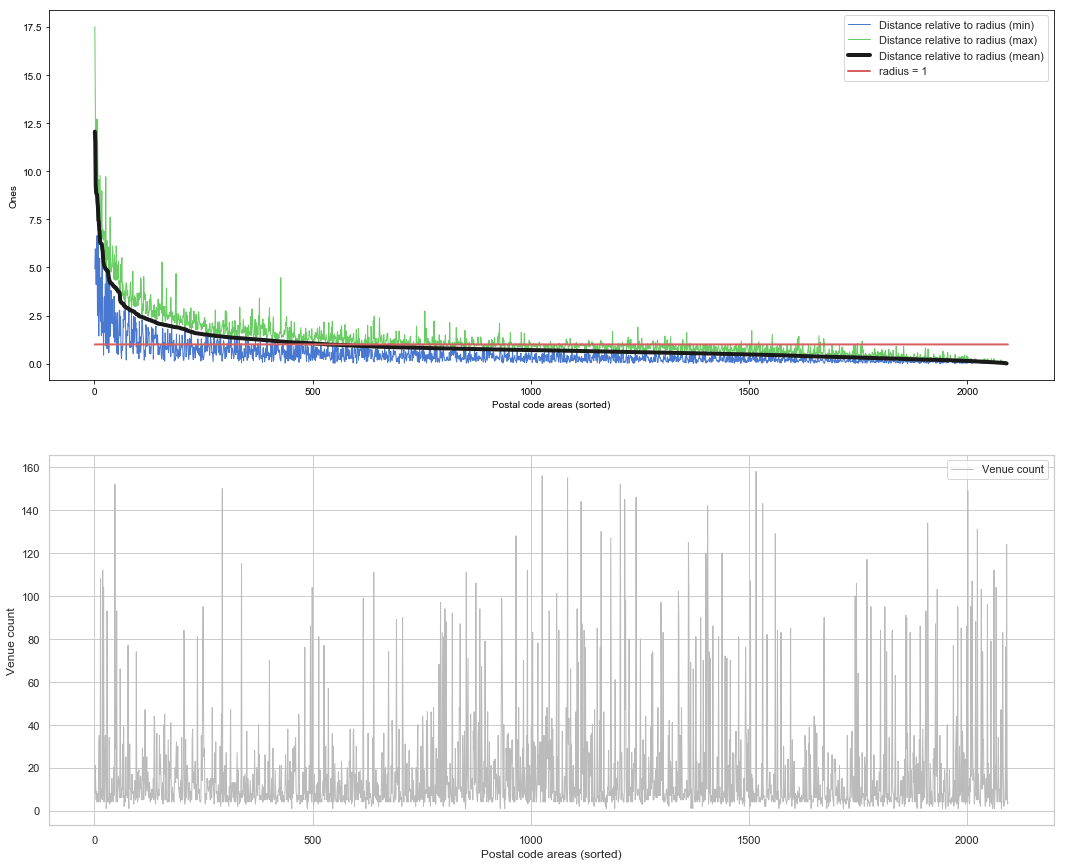

In [33]:
# create the image area and two vertical scales (ax2)

f, axs = plt.subplots(2, 2, figsize=(18,15))
plt.subplot(211)

sns.set(style="whitegrid")
sns.set_color_codes("muted")

legend_style = 'brief'

# draw the min and max with blue and with linewidth=1
sns.set_context("notebook", rc={'lines.linewidth': 1})
sns.lineplot(x="Postal code areas (sorted)", y="Distance relative to radius (min)", data=fs_analysis_df, legend=legend_style, color="b")
sns.lineplot(x="Postal code areas (sorted)", y="Distance relative to radius (max)", data=fs_analysis_df, legend=legend_style, color="g")

# draw the mean with a thicker black line and after the above to ensure it is clearly visible
sns.set_context("notebook", rc={'lines.linewidth': 4})
sns.lineplot(x="Postal code areas (sorted)", y="Distance relative to radius (mean)", data=fs_analysis_df, legend=legend_style, color="k")

# draw the line of value y=1 to show radius level for comparison
sns.set_context("notebook", rc={'lines.linewidth': 2})
sns.lineplot(x="Postal code areas (sorted)", y="Ones", data=fs_analysis_df, legend=legend_style, dashes=True, color="r")

plt.legend(labels=['Distance relative to radius (min)',
                   'Distance relative to radius (max)',
                   'Distance relative to radius (mean)',
                   'radius = 1'])
#plt.legend()

plt.subplot(212)

# first draw on background the count of venues with a light grey color
sns.set_context("notebook", rc={'lines.linewidth': 1})
sns.lineplot(x="Postal code areas (sorted)", y="Venue count", data=fs_analysis_df, legend=legend_style, color="#bbbbbb")
plt.legend(labels=['Venue count'])



The upper plot shows us that the venue data results from the _explore_ endpoint are not harmfully restricted by the radius parameter of the Foursquare request. That is, despite the radius value many postal code areas have venues mostly further away than the radius parameter of the call.  Even the distance to the closest venues may be longer than the calculated radius for the postal code area, as can be seen from the blue area on the left side of the upper plot.

The lower plot shows us that the amount of result venues varies regardless of the average venue distances from the postal code area center.  It would be a bad sign if all the areas with lots of venues would be on the right side of the plot, where the venues are on average closer than the radius: this could mean that there would be more venues to download, but the limit of 50 blocked us from getting them all.

In addition to the plots, the correlation analysis shows strong correlation between the min, mean and max values over the postal code areas, but a nonexistent correlation between these and the venue count over postal code areas.  This adheres to the plot visualizations.

To summarize this analysis 1, the download choices that were made did not create any observable bias that we can see.  Thus the venue data seems to cover the postal code areas in a representative manner.


### Step 4.2 - Analysis 2: Overlap of venues across postal code areas.

In dense city areas it can be that there are a lot of venues in a small area.  When using Foursquare's explore endpoint, it limits the results to a maximum of 50 result venues.  We tried to overcome this in the downloading process, but now we need to make sure that we succeeded.  Thus, there should not be such gaps that we have received only those venues very close to the postal code area center and would be missing a substantial amount of venus just a bit further.

Because of the way venues were downloaded, it is expected that some venues were returned for more than one postal code area.  For example, if a venue is on the border of two postal code areas, it is likely returned for both postal code areas, at least in areas of less venues.  Thus it exists in our Foursquare data twice, once for each postal code area.  **If we do not find enough this kind of overlap**, it may indicate that we have not downloaded a good enough coverage and we may be missing some venues.


In [34]:
fs_venue_df.head()

,PC,PC Latitude,PC Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance (km),Appearances
0,00100,60.17,24.93,4adcdb1ff964a5208b5f21e3,Konditoria Café Briossi,60.17,24.94,Bakery,0.74,2
1,00100,60.17,24.93,4adcdb1ff964a5208d5f21e3,Fazer Café,60.17,24.95,Café,1.09,2
2,00100,60.17,24.93,4adcdb1ff964a520a65f21e3,Café Strindberg,60.17,24.95,Café,1.07,3
3,00100,60.17,24.93,4adcdb20f964a520ce5f21e3,KuuKuu,60.18,24.93,Scandinavian Restaurant,0.42,3
4,00100,60.17,24.93,4adcdb20f964a520cf5f21e3,St. Urho's Pub,60.17,24.93,Beer Bar,0.23,3


There area 17702 distinct venues in the dataset.


,Venue in # Postal Code areas,Count of such venues,% of such venues
0,1,7512,42.44
1,2,4768,26.93
2,3,3125,17.65
3,4,1531,8.65
4,5,547,3.09
5,6,132,0.75
6,7,81,0.46
7,8,5,0.03
8,9,1,0.01


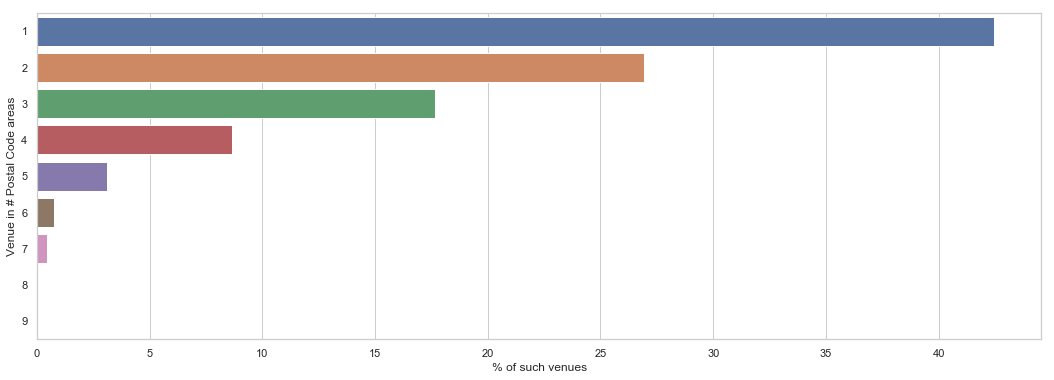

In [35]:
fs_analysis2_step1_df = fs_venue_df[["PC", "Venue Id"]].groupby("Venue Id").count()
fs_analysis2_step2_df = fs_analysis2_step1_df.reset_index().groupby('PC').count().reset_index().rename(columns={'PC':'Venue in # Postal Code areas', 'Venue Id':'Count of such venues'})
fs_distinct_venues = fs_analysis2_step2_df['Count of such venues'].sum()
fs_analysis2_step2_df['% of such venues'] = fs_analysis2_step2_df['Count of such venues'] * 100 / fs_distinct_venues

plt.figure(figsize=(18,6))
#sns.barplot(x='Venue appears in # in Postal Code areas', y='Count of such venues', data=fs_analysis2_1_df)
sns.barplot(x='% of such venues', y='Venue in # Postal Code areas', data=fs_analysis2_step2_df, orient='h')

print("There area {} distinct venues in the dataset.".format(fs_distinct_venues))
fs_analysis2_step2_df

(-1.1063226529715757,
 1.1003010787129321,
 -1.1190970773993598,
 1.1267668457561626)

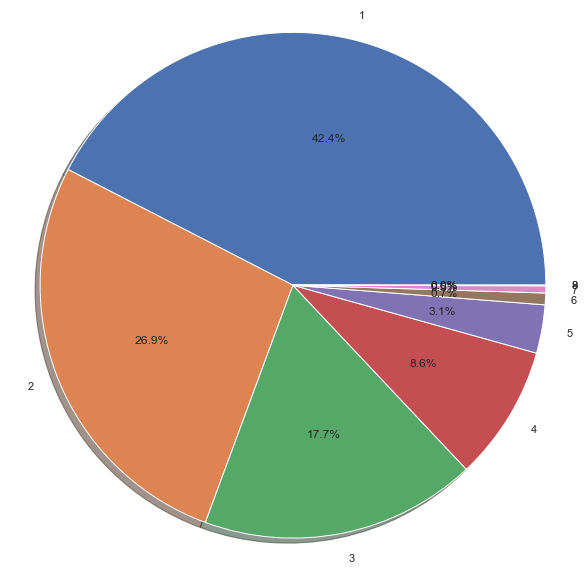

In [36]:
fig1, ax1 = plt.subplots(figsize=(10,10))
#plt.figure(figsize=(10,10))
ax1.pie(fs_analysis2_step2_df['Count of such venues'], labels=fs_analysis2_step2_df['Venue in # Postal Code areas'], autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


Above analysis shows us that:

- in total there are 17 702 distinct venues in our dataset
- less than half of the venues in the dataset are mentioned only by one postal code area.  That is, more than half of the venues are mentioned by at least two postal code areas.

This is a good sign because it is likely that our chosen venue gathering parameters (mainly the radius and then overcoming the limit of results) were successful in providing us a representative result for postal code areas, and likely not many venues were missed.

Next: show statistics on how postal code areas have shared venues with other postal code areas.

In [37]:
fs_venue_df.head()

,PC,PC Latitude,PC Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance (km),Appearances
0,00100,60.17,24.93,4adcdb1ff964a5208b5f21e3,Konditoria Café Briossi,60.17,24.94,Bakery,0.74,2
1,00100,60.17,24.93,4adcdb1ff964a5208d5f21e3,Fazer Café,60.17,24.95,Café,1.09,2
2,00100,60.17,24.93,4adcdb1ff964a520a65f21e3,Café Strindberg,60.17,24.95,Café,1.07,3
3,00100,60.17,24.93,4adcdb20f964a520ce5f21e3,KuuKuu,60.18,24.93,Scandinavian Restaurant,0.42,3
4,00100,60.17,24.93,4adcdb20f964a520cf5f21e3,St. Urho's Pub,60.17,24.93,Beer Bar,0.23,3


In [38]:
# This shows us how well connected a PC is to its neighboring PCs.
fs_analysis2_step3_df = fs_venue_df[['PC', 'Appearances']].groupby('PC').max()
fs_analysis2_step3_df.rename(columns={'Appearances':"PC's most shared venue's connections"}, inplace=True)
fs_analysis2_step3_df["Venues shared"] = fs_venue_df[fs_venue_df['Appearances'] > 1].groupby('PC').count()[['Appearances']]
fs_analysis2_step3_df['Venues shared'].fillna(0, inplace=True)
fs_analysis2_step3_df["Total venues"] = fs_venue_df.groupby('PC').count()[['Appearances']]
fs_analysis2_step3_df["Venues shared %"] = fs_analysis2_step3_df["Venues shared"] * 100 / fs_analysis2_step3_df["Total venues"]
fs_analysis2_step3_df = fs_analysis2_step3_df.reset_index()

fs_analysis2_step3_df.head()

,PC,PC's most shared venue's connections,Venues shared,Total venues,Venues shared %
0,00100,5,139.00,158,87.97
1,00120,5,149.00,152,98.03
2,00130,5,120.00,127,94.49
3,00140,4,119.00,128,92.97
4,00150,4,138.00,155,89.03


In [39]:
fs_analysis2_step3_df.sort_values(["Total venues", "Venues shared"], ascending=False, inplace=True)
fs_analysis2_step3_df['Postal code areas in order by total venues'] = list(range(1, fs_analysis2_step3_df.shape[0] + 1))
fs_analysis2_step3_df.head()

,PC,PC's most shared venue's connections,Venues shared,Total venues,Venues shared %,Postal code areas in order by total venues
0,00100,5,139.00,158,87.97,1
7,00180,3,77.00,156,49.36,2
4,00150,4,138.00,155,89.03,3
1,00120,5,149.00,152,98.03,4
834,33680,5,133.00,152,87.50,5


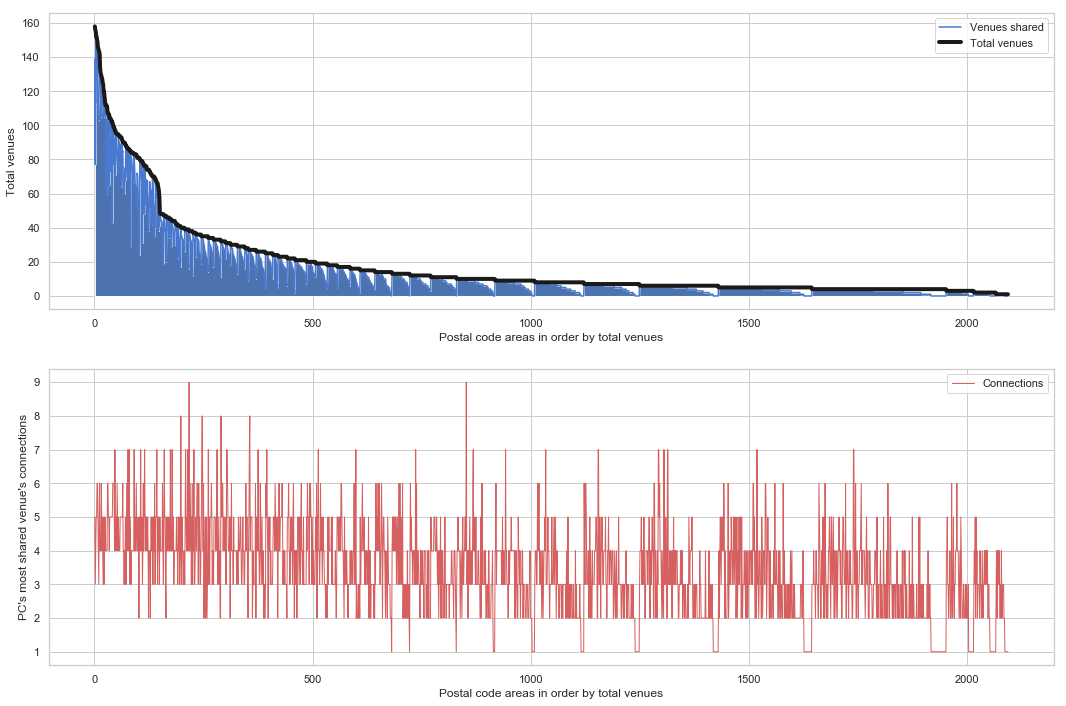

In [40]:
# create the image area and two vertical scales (ax2)

f, axs = plt.subplots(2, 2, figsize=(18,12))
plt.subplot(211)

sns.set(style="whitegrid")
sns.set_color_codes("muted")

legend_style = 'brief'

# draw the min and max with blue and with linewidth=1
#sns.set_context("notebook", rc={'lines.linewidth': 1})
#sns.lineplot(x="Postal code areas (sorted)", y="Distance relative to radius (min)", data=fs_analysis_df, legend=legend_style, color="b")
#sns.lineplot(x="Postal code areas (sorted)", y="Distance relative to radius (max)", data=fs_analysis_df, legend=legend_style, color="g")

sns.lineplot(x="Postal code areas in order by total venues", y="Venues shared", data=fs_analysis2_step3_df, legend=legend_style, color="b")
plt.fill_between(fs_analysis2_step3_df['Postal code areas in order by total venues'], fs_analysis2_step3_df['Venues shared'])
#plt.stackplot(fs_analysis2_step3_df['Total venues'])

# draw the mean with a thicker black line and after the above to ensure it is clearly visible
sns.set_context("notebook", rc={'lines.linewidth': 4})
sns.lineplot(x="Postal code areas in order by total venues", y="Total venues", data=fs_analysis2_step3_df, legend=legend_style, color="k")

# draw the line of value y=1 to show radius level for comparison
#sns.set_context("notebook", rc={'lines.linewidth': 2})
#sns.lineplot(x="Postal code areas (sorted)", y="Ones", data=fs_analysis_df, legend=legend_style, dashes=True, color="r")

plt.legend(labels=['Venues shared',
                   'Total venues'])

plt.subplot(212)

# first draw on background the count of venues with a light grey color
sns.set_context("notebook", rc={'lines.linewidth': 1})
sns.lineplot(x="Postal code areas in order by total venues", y="PC's most shared venue's connections", data=fs_analysis2_step3_df, legend=legend_style, color="r")
plt.legend(labels=['Connections'])


Above plots tell us how much the venue data is overlapping the postal code area borders.  In the upper plot the black line tells us the number of venues in a postal code area, over all postal code areas sorted to descending order of total venues.  The blue area below the black line tells us how many of that postal code area venues are shared with at least one other postal code area.  Increasing white area below the black line tells that there are venues that exist only for that postal code area.  As we can see, the area below the black line is mainly blue meaning that most postal code areas reach out to same venues with other postal code areas.  This tells us that quite likely we have received all venues that there are to receive.

The lower plot in red tells for each postal code area what is the most shared venue's connection count.  The postal code areas are in same order in the two above plots.  This plot varies quite steadily between 2 and 7 from left to right, showing only slight decreasing tendency.  This is good as it shows that the connectedness of a postal code area to its neighboring postal code areas does not depend very strongly on its total venue count.


As a summary of investigating the Foursquare venue data we can conclude that we have managed to download a good sample of the data, if not absolutely all.  This is good to know as matching together the postal code area shapes, exact borders and the Foursquare venue data API took some assumptions, which left out questions if we have harvested the data well enough.  We have.

### Step 4.3 - Analysis 3: The top 20 Finnish cities

Find out the top 20 cities in Finland by population.  See how well it covers whole Finland.

In [41]:
total_city_count = paavo_venues_df[['City', 'Inhabitants, total, 2017 (HE)']].groupby('City').sum().sort_values('Inhabitants, total, 2017 (HE)', ascending=False).reset_index().shape[0]
total_population_in_top20_cities = paavo_venues_df[['City', 'Inhabitants, total, 2017 (HE)']].groupby('City').sum().sort_values('Inhabitants, total, 2017 (HE)', ascending=False).reset_index().iloc[0:20, 1].sum()
total_population_in_Finland = paavo_venues_df[['City', 'Inhabitants, total, 2017 (HE)']].groupby('City').sum().sort_values('Inhabitants, total, 2017 (HE)', ascending=False).reset_index().iloc[:, 1].sum()
print("In Finland there are a total of", total_city_count, " cities or counties.")
print("Population of Finland is {} inhabitants.".format(total_population_in_Finland))
print("Population in top 20 cities + Savonlinna is {} inhabitants, which is {:.2f}% of the finnish population.".format(
    total_population_in_top20_cities, total_population_in_top20_cities * 100 / total_population_in_Finland))


In Finland there are a total of 308  cities or counties.
Population of Finland is 5316668 inhabitants.
Population in top 20 cities + Savonlinna is 2804379 inhabitants, which is 52.75% of the finnish population.


In [42]:
# filter our clustering and further analysis to the top n=20 cities in Finland (plus additional city of Savonlinna)
n = 20
filter_cities = paavo_venues_df.groupby('City').sum().sort_values('Inhabitants, total, 2017 (HE)', ascending=False).reset_index().iloc[0:n, 0].tolist()
filter_cities.append('Savonlinna')
print("Filter for {} cities: {}".format(len(filter_cities), filter_cities))


Filter for 21 cities: ['Helsinki', 'Espoo', 'Tampere', 'Vantaa', 'Oulu', 'Turku', 'Jyväskylä', 'Kuopio', 'Lahti', 'Pori', 'Kouvola', 'Joensuu', 'Lappeenranta', 'Vaasa', 'Hämeenlinna', 'Seinäjoki', 'Rovaniemi', 'Mikkeli', 'Kotka', 'Salo', 'Savonlinna']


### Step 4.4 - Analysis 4: Cluster postal code areas of top20 cities

To prepare for the clustering, we first need to standardise the data.

#### Step 4.4.1 - Standardize the data for clustering

In [54]:

# Prepare a list of columns that will be standardized and used in clustering

paavo_venues_stan_cols_list = paavo_venues_df.columns.tolist()
paavo_venues_stan_cols_list = paavo_venues_stan_cols_list[3:]
paavo_venues_stan_cols_list.remove('PC Longitude')
paavo_venues_stan_cols_list.remove('PC Latitude')
paavo_venues_stan_cols_list.remove('X coordinate in metres')
paavo_venues_stan_cols_list.remove('Y coordinate in metres')

# Create the standardized version of data.  Include PC and City columns for filtering for diffenent clusters.

standardized_df = paavo_venues_df[paavo_venues_stan_cols_list].astype('float64')
standardized_df = standardized_df.replace([np.inf, -np.inf], 0)
standardized_np = preprocessing.StandardScaler().fit_transform(standardized_df)
standardized_df = pd.DataFrame(standardized_np)
standardized_df['PC'] = paavo_venues_df['PC']
standardized_df['City'] = paavo_venues_df['City']
standardized_df.head()


,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,PC,City
0,-0.45,4.76,5.84,5.84,-0.32,9.46,0.31,4.72,-0.21,4.83,...,19.66,7.26,-0.07,-0.12,-0.11,18.29,-0.11,-0.04,00100,Helsinki
1,-0.46,1.38,13.32,5.59,-0.62,10.03,-0.06,4.96,-0.44,1.42,...,22.96,-0.14,-0.07,-0.12,-0.11,9.10,-0.11,-0.04,00120,Helsinki
2,-0.46,-0.31,2.45,4.55,-0.77,8.88,-0.23,4.72,-0.55,-0.30,...,6.48,-0.14,-0.07,-0.12,-0.11,-0.09,-0.11,-0.04,00130,Helsinki
3,-0.46,1.61,6.37,4.59,-0.56,6.59,0.08,4.72,-0.42,1.73,...,3.19,-0.14,-0.07,-0.12,-0.11,-0.09,-0.11,-0.04,00140,Helsinki
4,-0.46,2.10,5.18,5.71,-0.56,8.31,0.07,4.47,-0.38,2.22,...,9.78,-0.14,-0.07,-0.12,-0.11,9.10,-0.11,-0.04,00150,Helsinki


#### Step 4.4.2 - Prepare for clustering and cluster

We cluster the postal code areas of selected top20 cities.  So filter in only those top20 cities, and get clusters.

In [55]:
# cluster postal code areas

bare_clustering_1_df = standardized_df[standardized_df['City'].isin(filter_cities)]
bare_clustering_1_df = bare_clustering_1_df.drop(['PC', 'City'], axis=1)
#bare_clustering_1_df.head()

# CLUSTER !!!
k, clusters = get_KMeans_clusters_with_best_k(bare_clustering_1_df)


cluster count:  2, cluster sizes (sorted by size): [535, 142]
cluster count:  3, cluster sizes (sorted by size): [493, 164, 20]
cluster count:  4, cluster sizes (sorted by size): [460, 176, 32, 9]
cluster count:  5, cluster sizes (sorted by size): [397, 198, 57, 23, 2]
cluster count:  6, cluster sizes (sorted by size): [432, 179, 38, 24, 2, 2]
cluster count:  7, cluster sizes (sorted by size): [450, 174, 39, 11, 1, 1, 1]
cluster count:  8, cluster sizes (sorted by size): [527, 121, 21, 3, 2, 1, 1, 1]
cluster count:  9, cluster sizes (sorted by size): [407, 158, 71, 23, 12, 3, 1, 1, 1]
cluster count: 10, cluster sizes (sorted by size): [450, 177, 23, 10, 6, 4, 3, 2, 1, 1]
cluster count: 11, cluster sizes (sorted by size): [443, 117, 61, 33, 9, 4, 3, 3, 2, 1, 1]
cluster count: 12, cluster sizes (sorted by size): [438, 137, 58, 23, 10, 3, 3, 1, 1, 1, 1, 1]
cluster count: 13, cluster sizes (sorted by size): [454, 175, 19, 7, 6, 4, 3, 3, 2, 1, 1, 1, 1]
cluster count: 14, cluster sizes (sort

#### Step 4.4.3 - Relabel clusters based on cluster size

We want to rename the clusters in numbers in order so that the biggest cluster is 1, second biggest is 2 and so on.  This takes away any variance that appears to happen
if we run the clustering many times: cluster sizes stay, but the id's do not stay constant.  So do this cluster relabeling so that later analysis does not suffer from changing labels, if cluster sizes stay the same. 

In [56]:

ordered_new_labels = get_ordered_new_cluster_labels(clusters)

clusters_df = standardized_df[standardized_df['City'].isin(filter_cities)][['PC', 'City']]
clusters_df['Cluster tmp'] = clusters
clusters_df['Cluster'] = np.zeros(len(clusters))
for i in range(k):
    clusters_df.loc[clusters_df['Cluster tmp'] == i, 'Cluster'] = ordered_new_labels[i]
clusters_df['Cluster'] = clusters_df['Cluster'].astype('int')

# drop for cleaner merge.  Keep city in other purposes for city filtering...
clusters_df.drop(['Cluster tmp', 'City'], inplace=True, axis=1)
clusters_df.head()


,PC,Cluster
0,00100,6
1,00120,4
2,00130,4
3,00140,4
4,00150,4


#### Step 4.4.4 - Store clusters back to base data

In [57]:

# use a temp dataframe for convenience (if we run this cell multiple times, it doesnt mess up paavo_venues_df)
clusters_merge_tmp_df = paavo_venues_df[['PC']].merge(clusters_df, how='left', on='PC')
clusters_merge_tmp_df.rename(columns={'Cluster': 'Cluster #1'}, inplace=True)
clusters_merge_tmp_df = clusters_merge_tmp_df.fillna(0)

paavo_venues_df['Cluster #1'] = clusters_merge_tmp_df['Cluster #1']
paavo_venues_df['Cluster #1'] = paavo_venues_df['Cluster #1'].astype('int')
paavo_venues_df = paavo_venues_df[list_order_to_top(['PC', 'PC Name', 'City', 'Cluster #1'], paavo_venues_df.columns.tolist())]
paavo_venues_df.head()

,PC,PC Name,City,Cluster #1,Surface area,"Inhabitants, total, 2017 (HE)",Inhabitants per km2,Venues Total,Inhabitants per venue,Cafes Total,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,6,2.35,18284,"7,769.59",158,115.72,17,...,0,0,6,1,0,0,0,2,0,0
1,00120,Punavuori,Helsinki,4,0.41,7108,"17,168.67",152,46.76,18,...,0,0,7,0,0,0,0,1,0,0
2,00130,Kaartinkaupunki,Helsinki,4,0.43,1508,"3,515.48",127,11.87,16,...,0,0,2,0,0,0,0,0,0,0
3,00140,Kaivopuisto - Ullanlinna,Helsinki,4,0.93,7865,"8,440.28",128,61.45,12,...,0,0,1,0,0,0,0,0,0,0
4,00150,Eira - Hernesaari,Helsinki,4,1.37,9496,"6,944.93",155,61.26,15,...,0,0,3,0,0,0,0,1,0,0


In [58]:
paavo_venues_df.shape

(2093, 578)

### Step 4.5 - Analysis 5: Summarize cities (top 20)

Create city level summaries of the postal code areas within the cities.

In [59]:
# These columns are interesting to check quickly in summaries.  Create more of these sorted columns as needed.
columns_interesting = [
    'Surface area', 'Inhabitants, total, 2017 (HE)', 'Venues Total', 'Cafes Total', 'Restaurants Total',
    'Average age of inhabitants, 2017 (HE)', 'With education, total, 2017 (KO)', 'Academic degree - Higher level university degree, 2017 (KO)',
    'Average income of inhabitants, 2016 (HR)', 'Median income of inhabitants, 2016 (HR)',
    'Average size of households, 2017 (TE)', 'Average income of households, 2016 (TR)', 'Median income of households, 2016 (TR)',
    'Free-time residences, 2017 (RA)', 'Average floor area, 2017 (RA)', 'Workplaces, 2016 (TP)', 'Primary production, 2016 (TP)', 'Processing, 2016 (TP)',
    'Services, 2016 (TP)', 'Employed, 2016 (PT)', 'Unemployed, 2016 (PT)', 'Students, 2016 (PT)', 'Pensioners, 2016 (PT)'
]

# To create summaries, some columns are better summed up, while others are better for taking the average (mean).
# Create summaries with summing up the grouping, then replace the resulting dataframe's following fields from another
# grouping which has been used to take the average of column.
columns_summary_by_mean = [
    'Average age of inhabitants, 2017 (HE)', 'Average income of inhabitants, 2016 (HR)', 'Median income of inhabitants, 2016 (HR)',
    'Average size of households, 2017 (TE)', 'Average income of households, 2016 (TR)', 'Median income of households, 2016 (TR)',
    'Average floor area, 2017 (RA)'
]


City level summary:

In [60]:
# Create summary of the given dataframe.  Use sum as the summary method by default, but use mean as the summary method for columns in
# columns_summary_by_mean.  Additionally sort by chosen column.
def create_summary_df(source_df, grouping_col, sort_col, sort_ascending=False):
    summary_df = source_df.groupby(grouping_col).sum()
    summary_df[columns_summary_by_mean] = source_df.groupby(grouping_col).mean()[columns_summary_by_mean]
    summary_df.sort_values(by=[sort_col], ascending=sort_ascending, inplace=True)
    summary_df = summary_df.reset_index()
    return summary_df

print('create_summary_df() defined.')


create_summary_df() defined.


In [61]:
city_summary_df = create_summary_df(paavo_venues_df, 'City', 'Inhabitants, total, 2017 (HE)', False)
city_summary_df[['City'] + columns_interesting].head(5)

,City,Surface area,"Inhabitants, total, 2017 (HE)",Venues Total,Cafes Total,Restaurants Total,"Average age of inhabitants, 2017 (HE)","With education, total, 2017 (KO)","Academic degree - Higher level university degree, 2017 (KO)","Average income of inhabitants, 2016 (HR)",...,"Free-time residences, 2017 (RA)","Average floor area, 2017 (RA)","Workplaces, 2016 (TP)","Primary production, 2016 (TP)","Processing, 2016 (TP)","Services, 2016 (TP)","Employed, 2016 (PT)","Unemployed, 2016 (PT)","Students, 2016 (PT)","Pensioners, 2016 (PT)"
0,Helsinki,213.17,628760,5347,328,1417,40.27,405319,109449,"29,729.71",...,402,68.54,358148,371,38643,319127,297219,38834,46639,122330
1,Espoo,355.41,273029,2078,137,526,38.04,166765,49235,"32,666.04",...,1881,88.08,106230,128,18206,87893,126010,13693,21995,44233
2,Tampere,753.11,223117,1750,43,421,41.59,150606,27226,"24,286.94",...,3481,74.31,107222,191,21491,85537,93289,19621,21429,49175
3,Vantaa,239.87,215273,1359,71,272,38.71,122147,17165,"26,256.80",...,680,79.66,100705,257,23520,76927,99901,13013,15037,38263
4,Oulu,"2,613.83",199340,1073,18,305,38.18,127457,22201,"23,622.79",...,4003,85.97,75211,438,14874,59898,80996,15871,20161,37981


In [62]:
city_summary_df.iloc[:5,:15]
#city_summary_df.columns.tolist().index('Surface area')

,City,Cluster #1,Surface area,"Inhabitants, total, 2017 (HE)",Inhabitants per km2,Venues Total,Inhabitants per venue,Cafes Total,Inhabitants per cafe,Restaurants Total,Inhabitants per restaurant,PC Longitude,PC Latitude,X coordinate in metres,Y coordinate in metres
0,Helsinki,191,213.17,628760,"357,183.04",5347,"11,773.93",328,inf,1417,inf,"2,072.98","4,997.31",32188206,554137778
1,Espoo,79,355.41,273029,"78,957.50",2078,"6,561.55",137,inf,526,inf,"1,112.51","2,709.21",16819543,300437261
2,Tampere,70,753.11,223117,"53,889.00",1750,"6,262.66",43,inf,421,inf,808.65,"2,091.57",11183814,232035333
3,Vantaa,64,239.87,215273,"61,753.31",1359,"7,085.27",71,inf,272,inf,873.30,"2,110.38",13537031,234017488
4,Oulu,63,"2,613.83",199340,"39,999.95",1073,"12,200.11",18,inf,305,inf,996.00,"2,537.02",16817232,281386746


### Step 4.6 - Analysis 6: Cluster cities (top 20)

Cluster the cities themselves directly.  Use the city level summaries of their postal code areas as units to cluster.

---

# DONE UNTIL HERE, CONTINUE WITH CLUSTERING CITIES

Before that prepare the city level summaries (some columns via sum, some via mean etc...

---

Prepare structures for summaries:


In [ ]:
paavo_venues_df.head()

In [ ]:
cluster1_summary_df = create_summary_df(paavo_venues_df, 'Cluster #1', 'Cluster #1', True)
# add cluster count
cluster1_summary_df['Cluster #1 size'] = paavo_venues_df.groupby('Cluster #1').count().iloc[:,0]
cluster1_summary_df = cluster1_summary_df[list_order_to_top(['Cluster #1', 'Cluster #1 size'], cluster1_summary_df.columns.tolist())]
cluster1_summary_df[['Cluster #1', 'Cluster #1 size'] + columns_interesting]

In [ ]:
# Create a standardized version of Paavo data.  Don't include unnecessary columns

paavo_stan_cols = paavo_filtered_df.columns.tolist()
paavo_stan_cols = paavo_stan_cols[6:]
paavo_stan_df = paavo_filtered_df[paavo_stan_cols].astype('float64') # type conversions removes a warning
paavo_stan_np = preprocessing.StandardScaler().fit_transform(paavo_stan_df)
paavo_stan_df = pd.DataFrame(paavo_stan_np)
paavo_stan_df["PC"] = paavo_filtered_df["PC"]
paavo_stan_df["City"] = paavo_filtered_df["City"]
paavo_stan_df.head()

### Step 4.4 - Analysis 4: Cluster cities

### Step 4 - analysis 1: City totals

The data is now for each postal code area.  Lets check how the city wide total look like.  Limit us to the top 30 cities for now.

### Correlation XXX

In [ ]:
corr_df = paavo_venues_df.corr()

In [ ]:
column_of_interest = 'Restaurants Total'
#corr_df.sort_values(by=[column_of_interest], ascending=False, inplace=False)[[column_of_interest]]
#corr_df.sort_values(by=[column_of_interest], ascending=False, inplace=False)[[column_of_interest]].loc[["Venues Total", "Bar"]]
corr_restaurants_df = corr_df[[column_of_interest]].loc[paavo_stat_variables_list].sort_values(by=[column_of_interest], ascending=False, inplace=False)
corr_restaurants_df[corr_restaurants_df[column_of_interest].abs() > 0.5]
#corr_restaurants_df


### Step 3.1 - Prepare for analysis: onehot


One hot -encoding and additionally, the top 10 most common types of venues for each postal code area.

One hot -encoding: create a column for each kind of venue that we have for the neighborhoods (onehot encoding). Then summarize them by the neighborhood.  And finally find the 10 most common of the for each neighborhood.

Now *pc_venues_onehot_df* contains each venue as its own row.

Next get all postal code area venue offerings into one row by grouping them with PC, and keep their sum equal to one, meaning that if there are 2 airports, 2 trainstations and avideo store, both airport and trainstation columns get value 0.4 and video store would get 0.2 

In [ ]:
# venue grouping via means (above is with sums).  Check if this is needed later on, at least useful for the "10 most common venues for each postal code area" -analysis
onehot_venue_categories_gm_df = onehot_venue_categories_df.groupby('PC').mean().reset_index()
print("PC venues grouped shape", onehot_venue_categories_gm_df.shape)

# Merge the postal code -columns into the data so we can use it to filter data later
onehot_venue_categories_gm_df = onehot_venue_categories_gm_df.merge(paavo_filtered_df[["PC", "PC Name", "City"]], on="PC")
onehot_venue_categories_gm_df = onehot_venue_categories_gm_df[list_order_to_top(["PC", "PC Name", "City"], onehot_venue_categories_gm_df.columns.tolist())] 
onehot_venue_categories_gm_df.head()

### Step 3.2 - 10 most common venues for each postal code area

In [ ]:
#
# Helper function to focus attention on each neighborhoods most common venues
# Expect that unnecessary columns have been removed already
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

print("return_most_common_venues() defined.")


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
# top_columns is used later, too
top_columns = []
for ind in np.arange(num_top_venues):
    try:
        top_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pc_venues_sorted_df = pd.DataFrame(columns=["PC"] + top_columns)
pc_venues_sorted_df['PC'] = pc_venues_onehot_grouped_df['PC']

for ind in np.arange(pc_venues_onehot_grouped_df.shape[0]):
    pc_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(pc_venues_onehot_grouped_df.iloc[ind, 3:], num_top_venues)

pc_venues_sorted_df.head()

### Step 3.3 - Filter data

Paavo and downloaded FourSquare data covers whole of Finland.  Filter out the top 20 cities.  Plus Savonlinna :)

In [ ]:

# Turn filters on / off with True / False -values. For now only one filter
FILTER_POSTAL_CODE_AREAS = True

print("\n\n")

filter = None
if FILTER_POSTAL_CODE_AREAS:
    filt = [False for n in pc_venues_onehot_grouped_df['PC']]
    for city in filter_cities:
        print("Filtering for city: '{}'".format(city))
        city_filter = pc_venues_onehot_grouped_df['City'] == city
        filt = [c or f for c, f in zip(filt, city_filter)]
    filter = pd.Series(data = filt)
else:
    # Effectively no filter, but fill it so that it will pass all data through.
    filter = pd.Series(data = [True for n in pc_venues_onehot_grouped_df['PC']])

filter_passed_through = len([x for x in filter if x])

# the all() method is kind of 'and' operation for the whole series value, it returns True only
# if all of the values in the series are True.  Thus it means there is no filtering.
if filter.all():
    print("No data filtering defined.\n")
else:
    print("Filtering in use, proceeding to clustering with", filter_passed_through, "cases out of", pc_venues_onehot_grouped_df.shape[0], "possible cases.\n")


Finally, create a standardized version of the Paavo data.  This is used later in analysis / clustering.

### Step 3.4 - Clustering

1. Put Paavo-data and FourSquare data together for Kclustering.
2. Run clustering algorithm a few times to see how big value K can have so that clusters are still big enough (smallest resulting cluster has at least five (5) elements in it).
3. Use the found K to create the clustering that we continue to explore

### Step 3.5 - See clustering results

To check out what the clustering found, inspect the data.  But first put together a combined dataset of Paavo and FourSquare data, and add cluster info back into it.


In [ ]:

# We applied filtering for the clustering data, thus we need to apply filtering to the
# resulting data
f_pc_venues_sorted_df = pc_venues_sorted_df[filter].reset_index()

# add clustering labels
f_pc_venues_sorted_df.insert(0, 'Cluster Label', kmeans.labels_)

# merge to add latitude/longitude for each neighborhood
paavo_fs_merged_df = pd.merge(paavo_filtered_df.rename(columns={"PC Number": "PC"}), f_pc_venues_sorted_df, on='PC')
paavo_fs_merged_df = paavo_fs_merged_df.drop('index', 1)
print("\n\nThe merged, filtered and clustered data *paavo_fs_merged_df* contains", paavo_fs_merged_df.shape[0], "postal code areas and ",
      paavo_fs_merged_df.shape[1], " data columns.\n")

cols = paavo_fs_merged_df.columns
new_order_cols = list_order_to_top(["PC", "PC Name", "City", "Cluster Label"] + top_columns, cols)
paavo_fs_merged_df = paavo_fs_merged_df[new_order_cols]
paavo_fs_merged_df.head(10) # check the last columns!

#### Step 3.5.1 - Analysis 1 "Most common venue categories in clusters postal code areas"

In [ ]:
import operator

threshold_percentage = 10
print("For each cluster, for each postal code area in that cluster, consider those venue categories that are mentioned in 1st, 2nd or 3rd most common ones.")
print("For each cluster, show categories that make it into the top 3 in most of the postal code areas.  For example, if a 'cafe' makes it into the top 3 for")
print("every postal code area in the cluster, then category 'cafe' should have 100% appearance in the analysis below.  Threshold for showing is", threshold_percentage, "%.")
for c_id in range(kclusters):
    clust = paavo_fs_merged_df[paavo_fs_merged_df["Cluster Label"] == c_id]
    cluster_size = clust.shape[0]
    cluster_threshold = (threshold_percentage / 100) * clust.shape[0]
    print("\nCluster {} has {} rows.".format(c_id, cluster_size))

    cat_counts = {}
    for pos in range(4,7):
        for category in clust.iloc[:,pos].tolist():
            if category in cat_counts.keys():
                cat_counts[category] = cat_counts[category] + 1
            else:
                cat_counts[category] = 1

    for i in (range(len(cat_counts.keys()))):
        key = max(cat_counts.items(), key=operator.itemgetter(1))[0]
        if cat_counts[key] > cluster_threshold:
            print("{:>25} -- {:3} ({:2}%)".format(key, cat_counts[key], int(100*(cat_counts[key]/cluster_size))))
        cat_counts.pop(key, None)

#clust.groupby("1st Most Common Venue").count()
#clust.head()


Observations about typical postal code areas in clusters:
- clusters 0 and 1 are big and their typical top venues are about shopping and grocery stores.  Services like cafes or some sort of restaurant are on the list, but clearly behind the shopping super markets.
- clusters 2 and 3 are quite small and kind of marginal in this examination.  However, they seem to be quite clearly cafe and restaurant services oriented clusters.
- cluster 4 is kind of balanced between food/cafe services and supermarkets / grocery stores.
- cluster 5 is the most clearly cafe and restaurant services oriented cluster of all.



#### Step 3.5.2 - Analysis 2: compare average (over postal code areas) numbers for each cluster

1. Use the previous "one hot" format of each venue category, and sum up venues in each category in each postal code area.
2. Create an additional summary (column) of cafe activity in the postal code areas.
3. Combine together all of Paavo data and this one hot summary of FourSquare venues.  NOTE this creates a dataframe of 584 columns (onehot encoding creates a lot of columns)
4. we are ready to show (and explore) the average number (per postal code area) of each feature **WITHIN** the cluster.  Purpose is to see if clusters differ from each other in some easily noticeable way.


In [ ]:
# 1. revisit the onehot data, this time use 'sum' to summarize the data by postal code area

pc_venues_onehot_grouped_s_df = pc_venues_onehot_df.groupby('PC').sum().reset_index()
print("PC venues grouped (count) shape", pc_venues_onehot_grouped_s_df.shape)

pc_venues_onehot_grouped_s_df = pc_venues_onehot_grouped_s_df.merge(paavo_filtered_df[["PC", "PC Name", "City"]], on="PC")
pc_venues_onehot_grouped_s_df = pc_venues_onehot_grouped_s_df[list_order_to_top(["PC", "PC Name", "City"], pc_venues_onehot_grouped_s_df.columns.tolist())] 
pc_venues_onehot_grouped_s_df.head()


In [ ]:
# 3. merge...
paavo_fs_merged_df = pd.merge(paavo_fs_merged_df, pc_venues_onehot_grouped_s_df.drop(['PC Name', 'City'], axis=1, inplace=False), on="PC")
print("Shape of merged data:", paavo_fs_merged_df.shape)
# paavo_fs_merged_df.head()

In [ ]:
paavo_fs_merged_df.columns.tolist()[16:20]

In [ ]:
# 4. Show average numbers (over postal code areas) for each cluster


paavo_column_names = paavo_fs_merged_df.columns.tolist()

clus_df = paavo_fs_merged_df
clus_df = clus_df.groupby("Cluster Label").mean()
# in the following, columns 16 and 17 refer to X and Y coordinates of the postal code area.
clus_df = clus_df.drop(columns=["PC Longitude", "PC Latitude", paavo_column_names[16], paavo_column_names[17]])
# convert value of 'surface area' from square meters to square kilometers
clus_df[paavo_column_names[18]] = clus_df[paavo_column_names[18]] / 1000000
#clus_df = clus_df.astype("int")

#
# Change values in following columns into percentiges, which makes relative comparisons easier
#
clus_df.iloc[:, 26] = clus_df.iloc[:,26] / clus_df.iloc[:,25]
clus_df.iloc[:, 27] = clus_df.iloc[:,27] / clus_df.iloc[:,25]
clus_df.iloc[:, 28] = clus_df.iloc[:,28] / clus_df.iloc[:,25]
clus_df.iloc[:, 29] = clus_df.iloc[:,29] / clus_df.iloc[:,25]
clus_df.iloc[:, 30] = clus_df.iloc[:,30] / clus_df.iloc[:,25]
clus_df.iloc[:, 31] = clus_df.iloc[:,31] / clus_df.iloc[:,25]
clus_df.iloc[:, 35] = clus_df.iloc[:,35] / clus_df.iloc[:,32]
clus_df.iloc[:, 36] = clus_df.iloc[:,36] / clus_df.iloc[:,32]
clus_df.iloc[:, 37] = clus_df.iloc[:,37] / clus_df.iloc[:,32]
clus_df.iloc[:, 42] = clus_df.iloc[:,42] / clus_df.iloc[:,39]
clus_df.iloc[:, 43] = clus_df.iloc[:,43] / clus_df.iloc[:,39]
clus_df.iloc[:, 44] = clus_df.iloc[:,44] / clus_df.iloc[:,39]
clus_df.iloc[:, 45] = clus_df.iloc[:,45] / clus_df.iloc[:,39]
clus_df.iloc[:, 46] = clus_df.iloc[:,46] / clus_df.iloc[:,39]
clus_df.iloc[:, 47] = clus_df.iloc[:,47] / clus_df.iloc[:,39]
clus_df.iloc[:, 48] = clus_df.iloc[:,48] / clus_df.iloc[:,39]
clus_df.iloc[:, 49] = clus_df.iloc[:,49] / clus_df.iloc[:,39]
clus_df.iloc[:, 50] = clus_df.iloc[:,50] / clus_df.iloc[:,39]
clus_df.iloc[:, 51] = clus_df.iloc[:,51] / clus_df.iloc[:,39]
clus_df.iloc[:, 52] = clus_df.iloc[:,52] / clus_df.iloc[:,39]
clus_df.iloc[:, 53] = clus_df.iloc[:,53] / clus_df.iloc[:,39]
clus_df.iloc[:, 57] = clus_df.iloc[:,57] / clus_df.iloc[:,54]
clus_df.iloc[:, 58] = clus_df.iloc[:,58] / clus_df.iloc[:,54]
clus_df.iloc[:, 59] = clus_df.iloc[:,59] / clus_df.iloc[:,54]
clus_df.iloc[:, 70] = clus_df.iloc[:,70] / clus_df.iloc[:,69]
clus_df.iloc[:, 71] = clus_df.iloc[:,71] / clus_df.iloc[:,69]
clus_df.iloc[:, 72] = clus_df.iloc[:,72] / clus_df.iloc[:,69]
clus_df.iloc[:, 96] = clus_df.iloc[:,96] / clus_df.iloc[:,95]
clus_df.iloc[:, 97] = clus_df.iloc[:,97] / clus_df.iloc[:,95]
clus_df.iloc[:, 98] = clus_df.iloc[:,98] / clus_df.iloc[:,95]
clus_df.iloc[:, 99] = clus_df.iloc[:,99] / clus_df.iloc[:,95]
clus_df.iloc[:, 100] = clus_df.iloc[:,100] / clus_df.iloc[:,95]
clus_df.iloc[:, 101] = clus_df.iloc[:,101] / clus_df.iloc[:,95]


Below is data to explore.  Because of many aspects in Paavo data, this exploration is shown in many tables.

In [ ]:
print("For each cluster, average data of its postal code areas. Columns 6-10 are percentiles of the amount in column 5.")
clus_df.iloc[:, [0,1,2,3,25,26,28,29,30,31]]


In [ ]:
print("For each cluster, average data of its postal code areas. Columns 4-6 are percentiles of the amount in column 1.")
clus_df.iloc[:, 32:39]


In [ ]:
print("For each cluster, average data of its postal code areas. Columns 4-15 are percentiles of the amount in column 1.")
clus_df.iloc[:, 39:54]

In [ ]:
print("For each cluster, average data of its postal code areas.")
clus_df.iloc[:, 54:57]

In [ ]:
print("For each cluster, average data of its postal code areas.")
clus_df.iloc[:, 61:69]

In [ ]:
print("For each cluster, average data of its postal code areas. Columns 2-4 are percentiles of the amount in column 1.")
clus_df.iloc[:, 69:73]

In [ ]:
print("For each cluster, average data of its postal code areas. Columns 2-7 are percentiles of the amount in column 1.")
clus_df.iloc[:, 95:102]

Observations:
- cluster 1 postal code areas are on average by far the largest, while their population is also the smallest.  Cluster 0 follows cluster 1 on this, but not so heavily.  Yet both are remarkably different from other clusters in these regards.  In the field of education balance, these clusters are clearly less academic and more hands on, education that prepares directly for some profession like cook, mechanic, constructions etc.
- Cluster 2 has on average the smallest postal code areas and most dense by population, and is on average the most educated, clearly geared towards academic education.  It has proportionally the least kids (age under 15) on average, but then again most studends by a slight margin. Cluster 2 postal code areas have also the most jobs on average, by a clear margin, and they are mostly service area professions.  Economically cluster 2 areas have highest average income.
- Cluster 3 follows cluster 2, but now in such extremes.  Postal code areas are still rather small, and these have on average the most population, but not so densily populated (almost twice the area / population when compared to cluster 2).  Proportion of kids in these postal code areas is average in comparison to other clusters.  These postal codes are average on the job amounts they offer.  Cluster 3 areas have lowest average income.
- Clusters 4 and 5 are between above clusters, but closer to clusters 2 and 3 than 0 and 1.  Cluster 5 postal code areas are on average a bit smaller than cluster 4 counterparts, and cluster 5 has a small edge in academic education (mainly in high school level, not university level).  What divides clusters 4 and 5 is that cluster 5 postal code areas offer twice more jobs than cluster 4 counterparts, but cluster 4 inhabitants have on average better income than inhabitants in cluster 5.

It would appear that cluster 2 is areas in big city centers, and cluster 3 is perhaps the neighborhood around these center / downtown areas.  And similarly cluster 5 would be average city central areas, while cluster 4 are the surrounding neighborhoods.  Clusters 0 and 1 are rather on the rural side of the scale.  Perhaps also in the smaller cities the well earning people like to live a bit outside the center, where as in the biggest cities the best earning people live in the very centres.

#### Step 3.5.3 - Analysis 3: Visual inspection of clusters on map

Each dot on the map marks a postal code area that was involved in analysis. Dot is located roughly in the center of the postal code area.

Cluster colors:
- cluster 0: blue
- cluster 1: brown
- cluster 2: black
- cluster 3: grey
- cluster 4: pink
- cluster 5: red

Zoom into the map to see in more detail!

In [ ]:

my_color = "#050505"
#finland_latitude = 62.777754
finland_latitude = 65.0
finland_longitude = 26.199539
map_test = folium.Map(location=[finland_latitude, finland_longitude], zoom_start=5)

cluster_colors = ["#0505ff", "#cc8305", "#050505", "#707070", "#ff7575", "#ff0000"]
for i in range(paavo_fs_merged_df.shape[0]):
#for i in range(5):
    row = paavo_fs_merged_df.iloc[i,:]
#    print(row[0], row[1], row[2], row[14], row[15])
    
    # show postal code center location
    label = folium.Popup(row[0] + " " + row[1] + ", " + row[2] + ", cluster " + str(row[3]))
    my_color = cluster_colors[row[3]]
    folium.CircleMarker(
        [row[15], row[14]],
        radius=2,
        popup=label,
        color=my_color,
        fill_color=my_color,
        fill_opacity=0.8).add_to(map_test)

map_test

Observations:

Cluster 2 does indeed seem to be in the very center of biggest cities.  Then again cluster 5 is not just in smaller cities, but there are plenty cluster 5 areas in big cities as well.

Another observation is that these classifications and above attempt to understand them based on averages cannot be blindly trusted.  For example, one of Espoo's most wealthy inhabitan areas 'Westend' is classified to cluster 1.  It is likely to hold true for it that there are not so many services in the area, as it is mainly a neighborhood of big houses and estates, but clustering it together with actually dying rural areas is a sign that we need to watch out what we can deduce from average numbers.



#### Step 3.5.4 - Analysis 4: Compare citywise cluster percentages etc.

Check out how clusters are presented in each city.  That is, how the postal code areas in each city map to different clusters.

In [ ]:
paavo_fs_merged_df.iloc[0:5, 18:20]

In [ ]:
# use onehot encoding to be able to get cluster values into separate columns 
city_clusters_onehot_df = pd.get_dummies(paavo_fs_merged_df['Cluster Label'])
city_clusters_onehot_df['City'] = paavo_fs_merged_df['City']
city_clusters_onehot_df['Area (km2)'] = paavo_fs_merged_df.iloc[:, 18] / 1000000
city_clusters_onehot_df['Area (km2)'] = city_clusters_onehot_df['Area (km2)'].astype('int')
city_clusters_onehot_df['Population'] = paavo_fs_merged_df.iloc[:, 19].astype('int')
city_clusters_onehot_df['Cafe Summary'] = paavo_fs_merged_df['Cafe Summary'].astype('int')
city_clusters_onehot_df['Restaurant Summary'] = paavo_fs_merged_df['Restaurant Summary'].astype('int')

city_clusters_onehot_df['PC Area count'] = np.ones(city_clusters_onehot_df.shape[0]).astype('int')

city_clusters_onehot_df = city_clusters_onehot_df.groupby('City').sum()

# change cluster counts into percent values
for i in range(0, 6):
    None
    city_clusters_onehot_df[i] = 100 * (city_clusters_onehot_df[i] / city_clusters_onehot_df['PC Area count'])

city_clusters_onehot_df.sort_values(by=['Population'], ascending=False, inplace=True)
city_clusters_onehot_df["Biggest in Finland (population)"] = np.array(list(range(1, city_clusters_onehot_df.shape[0] + 1)))
city_clusters_onehot_df['Population by cafe'] = city_clusters_onehot_df['Population'] / city_clusters_onehot_df['Cafe Summary']
city_clusters_onehot_df['Population by cafe'] = city_clusters_onehot_df['Population by cafe'].astype('int')
city_clusters_onehot_df['Population by restaurant'] = city_clusters_onehot_df['Population'] / city_clusters_onehot_df['Restaurant Summary']
city_clusters_onehot_df['Population by restaurant'] = city_clusters_onehot_df['Population by restaurant'].astype('int')

city_clusters_onehot_df

One observation here is that only eight (8) of the cities have at all cluster 2 and 3 areas.  And without the exception of Vaasa cities have all kinds of cluster areas present, at least for a small degree.  These cities are mainly the upper end of the top 20 cities in Finland (measured by population)


In [ ]:
city_clusters_onehot_df[(city_clusters_onehot_df[2] > 0) | (city_clusters_onehot_df[3] > 0)]

Of the other cities, not all have cluster 4 areas.  These cities do have:

In [ ]:
city_clusters_onehot_df[(city_clusters_onehot_df[2] == 0) & (city_clusters_onehot_df[3] == 0) & (city_clusters_onehot_df[4] > 0)]

Cities left out of the two above 'groups' are following.  They are quite heavily cluster 1 oriented cities.  Also, they are mainly the lower end of the top 20 cities in Finland (measured by population)

In [ ]:
city_clusters_onehot_df[(city_clusters_onehot_df[2] == 0) & (city_clusters_onehot_df[3] == 0) & (city_clusters_onehot_df[4] == 0)]

In [ ]:

city_venues_df = pc_venues_onehot_df.groupby('PC').sum()
city_venues_df.head()
#pc_venues_onehot_df.head()


In [ ]:
paavo_fs_merged_df.head()

#### Step 3.5.5 - Analysis 5: find correlations between coffees and other data

FInd out if there is a linear correlation between coffees and some other data features.

In [ ]:
# run linear regression correlation between 'coffee sum' and other columns from column 17 onwards
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print("Test linear regression accuracies between 'Cafe Summary' and other columns")
#y = np.array(paavo_fs_merged_df.iloc[:, 123]).reshape(-1, 1)
y = np.array(paavo_fs_merged_df["Cafe Summary"]).reshape(-1, 1)
test_scores = []
test_scores_i = 0        # helper index for debugging
for i in range(18, paavo_fs_merged_df.shape[1]):
    colname = paavo_fs_merged_df.columns.tolist()[i]
    if colname != "Cafe Summary":
        X = np.array(paavo_fs_merged_df.iloc[:, i]).reshape(-1, 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

        reg = LinearRegression()
        reg = reg.fit(X_train, y_train)
        yhat = reg.predict(X_test)

        test_scores.append([test_scores_i, i, colname, reg.score(X_train, y_train), reg.score(X_test, y_test)])
        test_scores_i += 1
    
print("\nTop 20 best correlating columns: (descending order in training accuracy score)\n")
top_20 = []
for j in range(20):
    max_key = max(test_scores, key=operator.itemgetter(3))[0]
    top_20.append(test_scores[max_key])
    test_scores[max_key] = [0, 0, 0, 0, 0]
    #print(max_key, test_scores.pop(max_key), len(test_scores))

for k in range(len(top_20)):
    e = top_20[k]
    print("{1:2}. column index: {0[1]:3}     train accuracy: {0[3]:.2f}     test accuracy: {0[4]:5.2f}     column name: {0[2]}".format(e, k+1))
#    print(top_20[k])

In [ ]:
colname = paavo_fs_merged_df.columns[356]
print("Scatterplot between {} and {}".format(colname, "Cafe Summary"))

paavo_fs_merged_df.plot(kind='scatter', x=colname, y='Cafe Summary', figsize=(10,6), color="darkblue")
plt.show()

In [ ]:
colname = paavo_fs_merged_df.columns[49]
print("Scatterplot between {} and {}".format(colname, "Cafe Summary"))

paavo_fs_merged_df.plot(kind='scatter', x=colname, y='Cafe Summary', figsize=(10,6), color="darkblue")
plt.show()